<h2><font color="#004D7F" size=6>TCGA Data Analysis Tool 1.0 </font></h2>
<h3><font color="#004D7F" size=4>- Jorge Iván Díaz Riaño PhD(c)  </font></h3>

<h1><font color="#004D7F" size=4>1. Loading and preprocessing data</font></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<h1><font color="#004D7F" size=4>1.1. Loading required packages and libraries </font></h1>

In [2]:
from IPython.display import display, HTML
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree


from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
from matplotlib.colors import LinearSegmentedColormap
import warnings
import io
from ipywidgets import FileUpload, Button
from IPython.display import display
from sklearn.cluster import DBSCAN
from scipy.stats import expon
from datetime import datetime

<h1><font color="#004D7F" size=4>1.2. Creating directory data structure </font></h1>

In [3]:
projectName = "CPTAC-3"
# Get the current working directory
working_directory = os.getcwd()
print(working_directory)
# Get the current date
current_date = datetime.now()
# Format the date as YYMMDD
formatted_date = current_date.strftime('%y%m%d')
# Define directory paths
output_directory = os.path.join(working_directory, f"{formatted_date}_TCGA_{projectName}_Output")
overview_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}_Overview")
toPlots_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}_Plots")
toPlotsCutoff_directory = os.path.join(toPlots_directory, f"{formatted_date}_TCGA_{projectName}_Cutoff")
toData_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}_Data")
toDataCutoff_directory = os.path.join(toData_directory, f"{formatted_date}_TCGA_{projectName}_Cutoff")
todea_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}_DEA")
deainput_directory = os.path.join(todea_directory, f"{formatted_date}_TCGA_{projectName}_DEA_Input")
deaoutput_directory = os.path.join(todea_directory, f"{formatted_date}_TCGA_{projectName}_DEA_Output")
# Create directories if they don't exist
os.makedirs(output_directory, exist_ok=True)
os.makedirs(overview_directory, exist_ok=True)
os.makedirs(toPlots_directory, exist_ok=True)
os.makedirs(toPlotsCutoff_directory, exist_ok=True)
os.makedirs(toData_directory, exist_ok=True)
os.makedirs(toDataCutoff_directory, exist_ok=True)
os.makedirs(todea_directory, exist_ok=True)
os.makedirs(deainput_directory, exist_ok=True)
os.makedirs(deaoutput_directory, exist_ok=True)
print("Directories created successfully:")
print(output_directory)
print(overview_directory)
print(toPlots_directory)
print(toPlotsCutoff_directory)
print(toData_directory)
print(toDataCutoff_directory)
print(todea_directory)
print(deainput_directory)
print(deaoutput_directory)

C:\Users\TTUSVM\Documents\TCGA2
Directories created successfully:
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_Overview
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_Overview\240606_TCGA_CPTAC-3_Plots
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_Overview\240606_TCGA_CPTAC-3_Plots\240606_TCGA_CPTAC-3_Cutoff
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_Overview\240606_TCGA_CPTAC-3_Data
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_Overview\240606_TCGA_CPTAC-3_Data\240606_TCGA_CPTAC-3_Cutoff
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_DEA
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_DEA\240606_TCGA_CPTAC-3_DEA_Input
C:\Users\TTUSVM\Documents\TCGA2\240606_TCGA_CPTAC-3_Output\240606_TCGA_CPTAC-3_DEA\

<h1><font color="#004D7F" size=4>1.3. Loading input table </font></h1>

In [4]:
dataset=input("Enter path for csv clinical (TPM and clinical variables) file: ") 
dataset_raw=input("Enter path for csv raw count file: ")
#C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv GBM Clinical
#C:\\Users\\TTUSVM\\Documents\\TCGA2\Output\\240425_TCGA-PAAD\\240425_TCGA-PAAD_tpm_clinical.csv   PAAD Clinical
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_TCGA-PAAD240425_TCGA-PAAD_raw-counts.csv PAAD Raw
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv CPTAC-3 Clinical
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_raw-counts.csv CPTAC-3 RawCounts
#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3\240502_CPTAC-3_tpm_clinical.csv CPTAC-3-normal clinical
#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3\240502_CPTAC-3_tpm_clinical.csv CPTAC-3-normal RawCounts

Enter path for csv clinical (TPM and clinical variables) file: C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv
Enter path for csv raw count file: C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_raw-counts.csv


In [5]:
# replace empty/invalid values with NaN
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df.head(4)

MAGEC2      TRO  MAGEB2    MAGED2  MAGEB4  MAGEA9  MAGEA10  \
sample                                                                     
C3L-00017-02     0.0   2.7888     0.0  106.6235     0.0     0.0   0.0475   
C3L-00102-01     0.0   6.9490     0.0  146.8381     0.0     0.0   0.0000   
C3L-00189-02     0.0  16.1324     0.0  175.4755     0.0     0.0   0.0580   
C3L-00277-03     0.0   5.6272     0.0  133.2166     0.0     0.0   0.2566   

               TRIM28  MAGEA4  MAGED4  ...  treatment_arm  treatment_dose  \
sample                                 ...                                  
C3L-00017-02  64.7977     0.0  0.0143  ...            NaN             NaN   
C3L-00102-01  77.6363     0.0  0.0170  ...            NaN             NaN   
C3L-00189-02  57.8380     0.0  0.0350  ...            NaN             NaN   
C3L-00277-03  56.2706     0.0  0.0000  ...            NaN             NaN   

              treatment_dose_units  treatment_effect  \
sample                                                 
C3L-00017-02                   NaN               NaN   
C3L-00102-01                   NaN               NaN   
C3L-00189-02                   NaN               NaN   
C3L-00277-03                   NaN               NaN   

              treatment_effect_indicator  treatment_frequency  \
sample                                                          
C3L-00017-02                         NaN                  NaN   
C3L-00102-01                         NaN                  NaN   
C3L-00189-02                         NaN                  NaN   
C3L-00277-03                         NaN                  NaN   

              treatment_intent_type  treatment_or_therapy  treatment_outcome  \
sample                                                                         
C3L-00017-02                    NaN                   NaN                NaN   
C3L-00102-01                    NaN                   NaN                NaN   
C3L-00189-02                    NaN                   NaN                NaN   
C3L-00277-03                    NaN                   NaN                NaN   

              treatment_type  
sample                        
C3L-00017-02             NaN  
C3L-00102-01             NaN  
C3L-00189-02             NaN  
C3L-00277-03             NaN  

[4 rows x 203 columns]

In [6]:
# Count of null data points
print(df.isnull().sum())

MAGEC2                     0
TRO                        0
MAGEB2                     0
MAGED2                     0
MAGEB4                     0
                        ... 
treatment_frequency      179
treatment_intent_type    179
treatment_or_therapy     179
treatment_outcome        179
treatment_type           179
Length: 203, dtype: int64


In [7]:
# drop columns with >X NaN's
df = df.loc[:, df.isnull().mean() < .5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, C3L-00017-02 to C3N-04284-01
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MAGEC2                             179 non-null    float64
 1   TRO                                179 non-null    float64
 2   MAGEB2                             179 non-null    float64
 3   MAGED2                             179 non-null    float64
 4   MAGEB4                             179 non-null    float64
 5   MAGEA9                             179 non-null    float64
 6   MAGEA10                            179 non-null    float64
 7   TRIM28                             179 non-null    float64
 8   MAGEA4                             179 non-null    float64
 9   MAGED4                             179 non-null    float64
 10  MAGEC1                             179 non-null    float64
 11  MAGEA8                             179 non-

In [8]:
df.describe()
# Write DataFrame description to CSV
df.describe().to_csv(os.path.join(toData_directory, 'DescriptiveStatistics.csv'))

<h1><font color="#004D7F" size=5>2. Visualization</font></h1>

In [9]:
df_numeric = df.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"
]
#df_numeric = df_numeric[column_order]
df_numeric=df_numeric[column_order]

<h1><font color="#004D7F" size=4>2.1 Distribution of TPMs expression.</font></h1>

In [ ]:
#toPlots_directory="C:240503_TCGA_CPTAC-3_Output/240503_TCGA_CPTAC-3_Overview/240503_TCGA_CPTAC-3_Plots/"

In [10]:
# Set colors
colors_pastel = sns.color_palette("Set2")

def plot_gene_histograms_type1(gene_list):
    num_genes = len(gene_list)
    num_rows = (num_genes // 6) + (1 if num_genes % 6 != 0 else 0)  # Calculate number of rows
    plt.figure(figsize=(15, 2 * num_rows))
    for i, gene in enumerate(gene_list, start=1):
        plt.subplot(num_rows, 6, i)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[2], edgecolor='black')
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type1_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()
    
def plot_gene_histograms_type2(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[5], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type2_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()

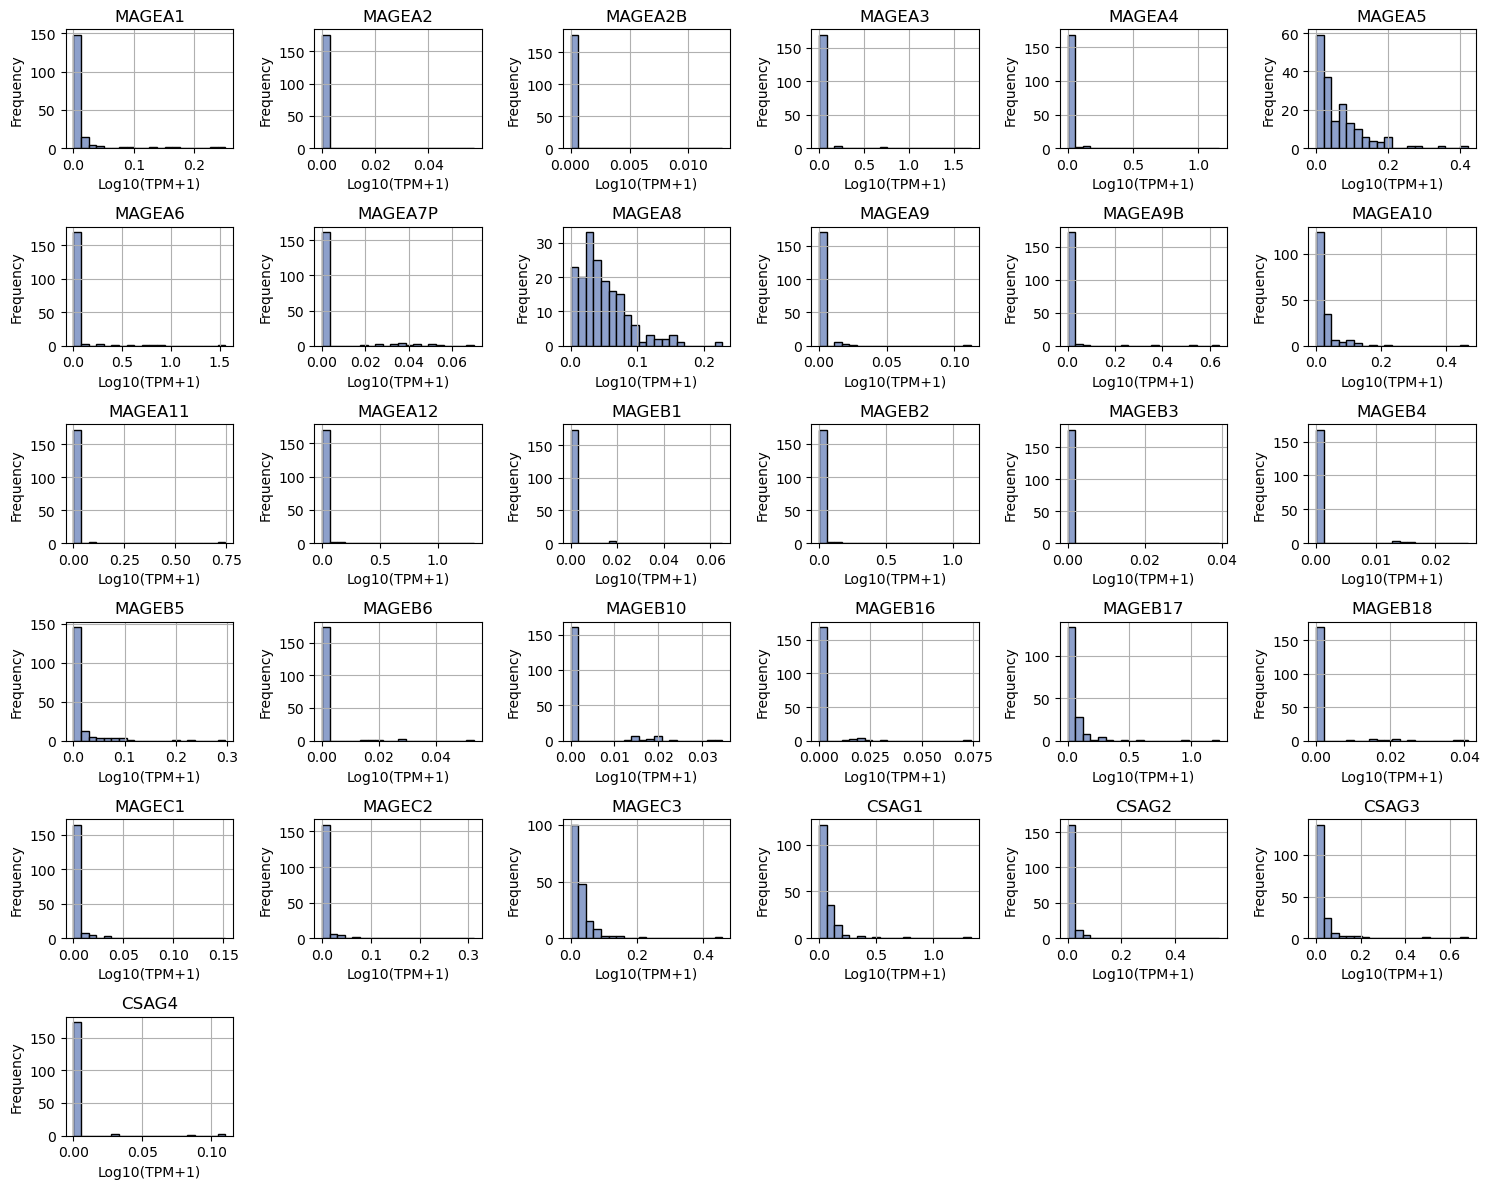

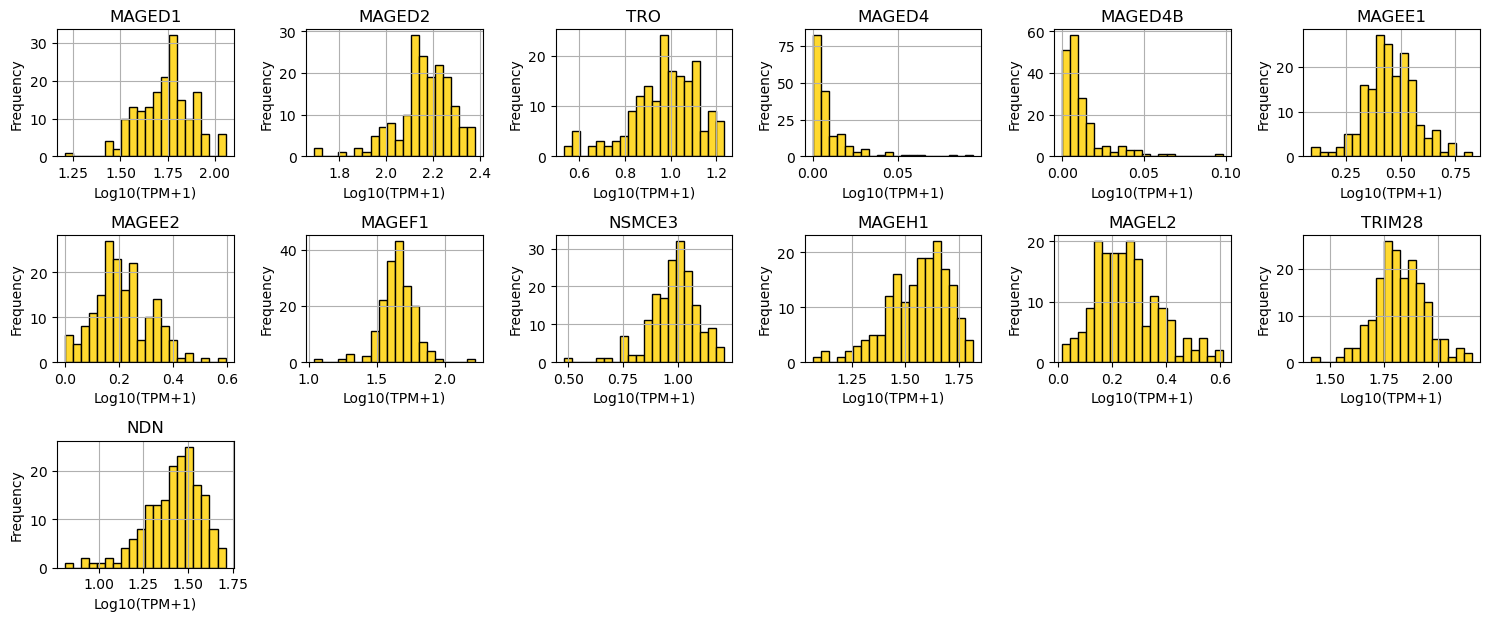

In [11]:
Type1 = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3","CSAG1", "CSAG2", "CSAG3", "CSAG4"]
Type2 = [ "MAGED1", "MAGED2", "TRO","MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"]
plot_gene_histograms_type1(Type1)
plot_gene_histograms_type2(Type2)

<h1><font color="#004D7F" size=4>2.1.1 Expression of genes in Normal vs Tumor.</font></h1>

In [12]:
Type1 = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3","CSAG1", "CSAG2", "CSAG3", "CSAG4"]

In [13]:
dataset=input("Enter path for csv clinical (TPM and clinical variables) file: ") 
datasetnormal=input("Enter path for csv file: ") 

#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv CPTAC-3 Clinical
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_raw-counts.csv CPTAC-3 RawCounts
#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3-normal\240502_CPTAC-3-normal_tpm_clinical.csv CPTAC-3-normal clinical

#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3\240502_CPTAC-3_tpm_clinical.csv CPTAC-3-normal RawCounts

Enter path for csv clinical (TPM and clinical variables) file: C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv
Enter path for csv file: C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3-normal\240502_CPTAC-3-normal_tpm_clinical.csv


In [14]:
# replace empty/invalid values with NaN
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df=df[Type1]
df

MAGEA1  MAGEA2  MAGEA2B  MAGEA3  MAGEA4  MAGEA5  MAGEA6  \
sample                                                                  
C3L-00017-02  0.0000     0.0      0.0  0.0000  0.0000  0.5848   0.000   
C3L-00102-01  0.0000     0.0      0.0  0.0000  0.0000  0.1738   0.000   
C3L-00189-02  0.0000     0.0      0.0  0.0000  0.0000  0.1785   0.000   
C3L-00277-03  0.0000     0.0      0.0  0.0000  0.0000  1.1846   0.000   
C3L-00401-02  0.0000     0.0      0.0  0.0000  0.0000  0.3063   0.000   
...              ...     ...      ...     ...     ...     ...     ...   
C3N-04119-02  0.0000     0.0      0.0  0.0000  0.0268  0.3503   0.000   
C3N-04126-02  0.0373     0.0      0.0  0.0000  0.1450  0.1355   0.000   
C3N-04282-01  0.0000     0.0      0.0  0.0930  0.0000  0.2625   0.000   
C3N-04283-03  0.2137     0.0      0.0  0.0000  0.0000  0.0776   0.000   
C3N-04284-01  0.4183     0.0      0.0  4.1918  0.1072  0.1753   2.955   

              MAGEA7P  MAGEA8  MAGEA9  ...  MAGEB16  MAGEB17  MAGEB18  MAGEC1  \
sample                                 ...                                      
C3L-00017-02      0.0  0.0000     0.0  ...      0.0   0.0000      0.0  0.0000   
C3L-00102-01      0.0  0.1732     0.0  ...      0.0   0.0000      0.0  0.0000   
C3L-00189-02      0.0  0.1423     0.0  ...      0.0   0.2609      0.0  0.0197   
C3L-00277-03      0.0  0.1259     0.0  ...      0.0   0.0000      0.0  0.0000   
C3L-00401-02      0.0  0.2137     0.0  ...      0.0   0.0000      0.0  0.0000   
...               ...     ...     ...  ...      ...      ...      ...     ...   
C3N-04119-02      0.0  0.0000     0.0  ...      0.0   0.0512      0.0  0.0000   
C3N-04126-02      0.0  0.0540     0.0  ...      0.0   0.1585      0.0  0.0150   
C3N-04282-01      0.0  0.0698     0.0  ...      0.0   0.1023      0.0  0.0000   
C3N-04283-03      0.0  0.1857     0.0  ...      0.0   0.0454      0.0  0.0000   
C3N-04284-01      0.0  0.2563     0.0  ...      0.0   1.0935      0.0  0.0259   

              MAGEC2  MAGEC3   CSAG1   CSAG2   CSAG3   CSAG4  
sample                                                        
C3L-00017-02  0.0000  0.0000  0.5045  0.0000  0.0000  0.0000  
C3L-00102-01  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
C3L-00189-02  0.0000  0.1825  0.0770  0.1552  0.0000  0.0000  
C3L-00277-03  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
C3L-00401-02  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
...              ...     ...     ...     ...     ...     ...  
C3N-04119-02  0.0000  0.0597  0.0755  0.0000  0.0762  0.0000  
C3N-04126-02  0.1921  0.0462  0.2338  0.0000  0.4125  0.0000  
C3N-04282-01  0.0000  0.1790  0.0000  0.0000  0.0000  0.0000  
C3N-04283-03  0.0000  0.0000  0.1339  0.0000  0.1350  0.0000  
C3N-04284-01  0.1380  0.0199  1.3612  0.0000  0.1017  0.0729  

[179 rows x 31 columns]

In [15]:
# replace empty/invalid values with NaN
datanormal= pd.read_csv(datasetnormal, sep=',')
dfnormal = pd.DataFrame(datanormal)
dfnormal.replace("\'--", np.nan, inplace=True)
dfnormal.replace('not reported', np.nan, inplace=True)
dfnormal.replace('Not Reported', np.nan, inplace=True)
dfnormal.set_index('sample', inplace=True)
dfnormal=dfnormal[Type1]
dfnormal

MAGEA1  MAGEA2  MAGEA2B  MAGEA3  MAGEA4  MAGEA5  MAGEA6  \
sample                                                                         
C3L-00017-04-normal  0.0000     0.0      0.0  0.0000     0.0  0.6988  0.0000   
C3L-00102-06-normal  0.0000     0.0      0.0  0.0000     0.0  0.0000  0.0000   
C3L-00589-06-normal  0.0000     0.0      0.0  0.0000     0.0  0.5272  0.0000   
C3L-00622-04-normal  0.0000     0.0      0.0  0.0000     0.0  0.0000  0.0000   
C3L-00640-06-normal  0.0000     0.0      0.0  0.0404     0.0  0.0000  0.0000   
...                     ...     ...      ...     ...     ...     ...     ...   
C3N-03069-03-normal  0.1401     0.0      0.0  0.0338     0.0  0.0000  0.0322   
C3N-03173-06-normal  0.0000     0.0      0.0  0.0000     0.0  0.2273  0.0000   
C3N-03440-04-normal  0.0000     0.0      0.0  0.0000     0.0  0.0000  0.0000   
C3N-03780-04-normal  0.0000     0.0      0.0  0.0000     0.0  0.0537  0.0000   
C3N-04283-04-normal  0.0000     0.0      0.0  0.0000     0.0  0.0000  0.0000   

                     MAGEA7P  MAGEA8  MAGEA9  ...  MAGEB16  MAGEB17  MAGEB18  \
sample                                        ...                              
C3L-00017-04-normal   0.0000  0.0557     0.0  ...      0.0   0.0817      0.0   
C3L-00102-06-normal   0.0000  0.0593     0.0  ...      0.0   0.5215      0.0   
C3L-00589-06-normal   0.0000  0.0000     0.0  ...      0.0   0.1713      0.0   
C3L-00622-04-normal   0.0752  0.2099     0.0  ...      0.0   0.1760      0.0   
C3L-00640-06-normal   0.0000  0.0908     0.0  ...      0.0   0.0000      0.0   
...                      ...     ...     ...  ...      ...      ...      ...   
C3N-03069-03-normal   0.0000  0.1268     0.0  ...      0.0   1.5996      0.0   
C3N-03173-06-normal   0.0000  0.2265     0.0  ...      0.0   0.0665      0.0   
C3N-03440-04-normal   0.0000  0.2102     0.0  ...      0.0   0.9762      0.0   
C3N-03780-04-normal   0.0000  0.2141     0.0  ...      0.0   0.8166      0.0   
C3N-04283-04-normal   0.0000  0.0680     0.0  ...      0.0   0.1663      0.0   

                     MAGEC1  MAGEC2  MAGEC3   CSAG1  CSAG2   CSAG3   CSAG4  
sample                                                                      
C3L-00017-04-normal  0.0000     0.0  0.0715  0.0000    0.0  0.0000  0.0000  
C3L-00102-06-normal  0.0000     0.0  0.0760  0.0000    0.0  0.0000  0.0000  
C3L-00589-06-normal  0.0130     0.0  0.0200  0.0000    0.0  0.0000  0.0731  
C3L-00622-04-normal  0.0000     0.0  0.0000  0.0000    0.0  0.0000  0.0000  
C3L-00640-06-normal  0.0000     0.0  0.0000  0.0655    0.0  0.0000  0.0000  
...                     ...     ...     ...     ...    ...     ...     ...  
C3N-03069-03-normal  0.0141     0.0  0.0000  0.0000    0.0  0.1107  0.0000  
C3N-03173-06-normal  0.0000     0.0  0.0000  0.0000    0.0  0.0000  0.0000  
C3N-03440-04-normal  0.0000     0.0  0.0599  0.0000    0.0  0.0000  0.0000  
C3N-03780-04-normal  0.0000     0.0  0.0183  0.0000    0.0  0.0000  0.0000  
C3N-04283-04-normal  0.0000     0.0  0.0194  0.0491    0.0  0.0495  0.0000  

[66 rows x 31 columns]

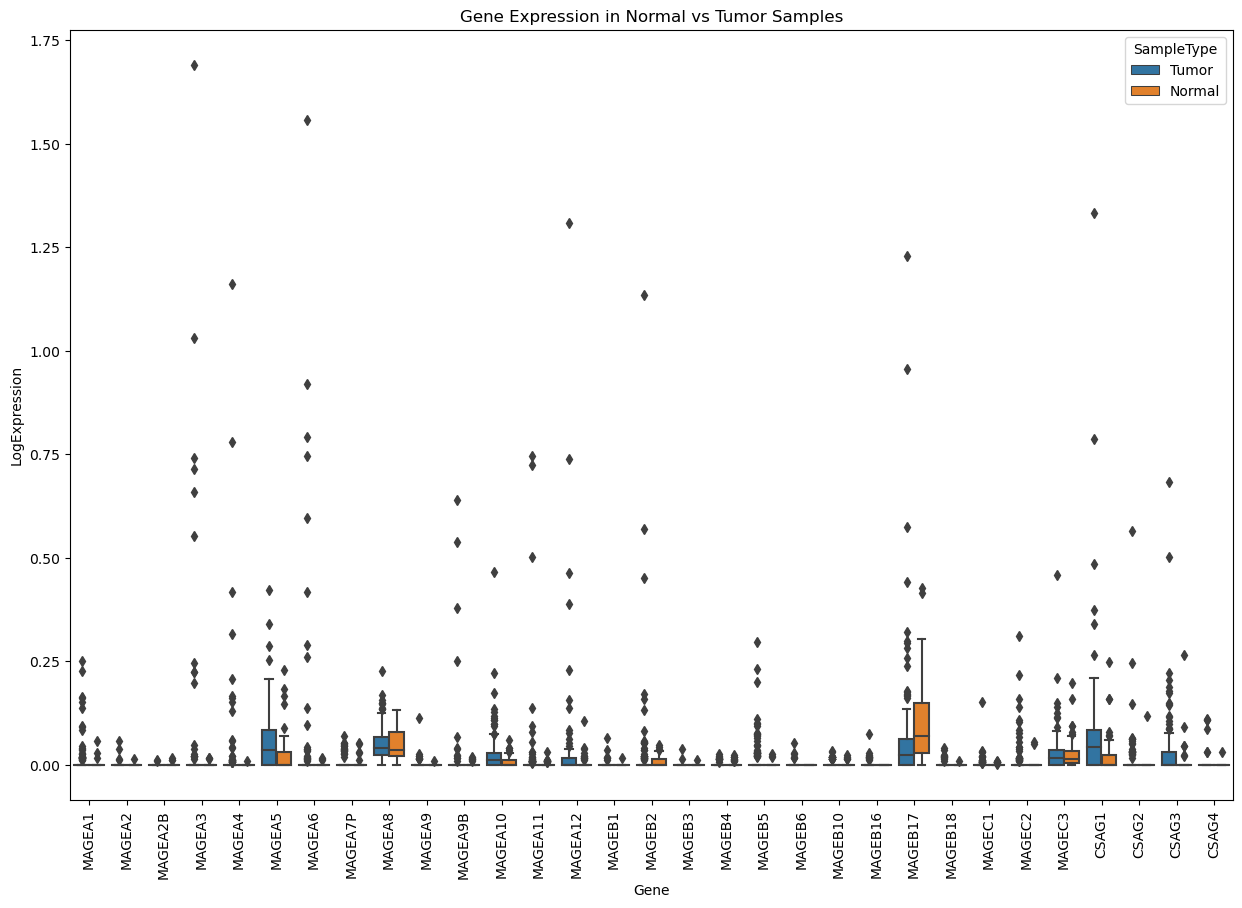

In [16]:
# Add a new column to indicate whether the sample is "normal" or "tumor"
df['SampleType'] = 'Tumor'
dfnormal['SampleType'] = 'Normal'

# Concatenate the selected columns from both data frames while retaining the original indices
combined_df = pd.concat([df, dfnormal], ignore_index=False)
combined_df
# Melt the DataFrames to a long format
df_melted = df.melt(id_vars=['SampleType'], var_name='Gene', value_name='Expression')
dfnormal_melted = dfnormal.melt(id_vars=['SampleType'], var_name='Gene', value_name='Expression')

# Concatenate the melted DataFrames
combined_df = pd.concat([df_melted, dfnormal_melted], ignore_index=True)

# Transform the expression values to log10(Expression + 1)
combined_df['LogExpression'] = np.log10(combined_df['Expression'] + 1)
combined_df.to_csv(os.path.join(toData_directory, 'CombinedExpressionNormalvsTumor.csv'))

# Create boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=combined_df, x='Gene', y='LogExpression', hue='SampleType')
plt.xticks(rotation=90)
plt.title('Gene Expression in Normal vs Tumor Samples')
plt.savefig(os.path.join(toPlots_directory, 'type1_ExpressionNormalTumor_histogram.png'), dpi=300)
plt.show()

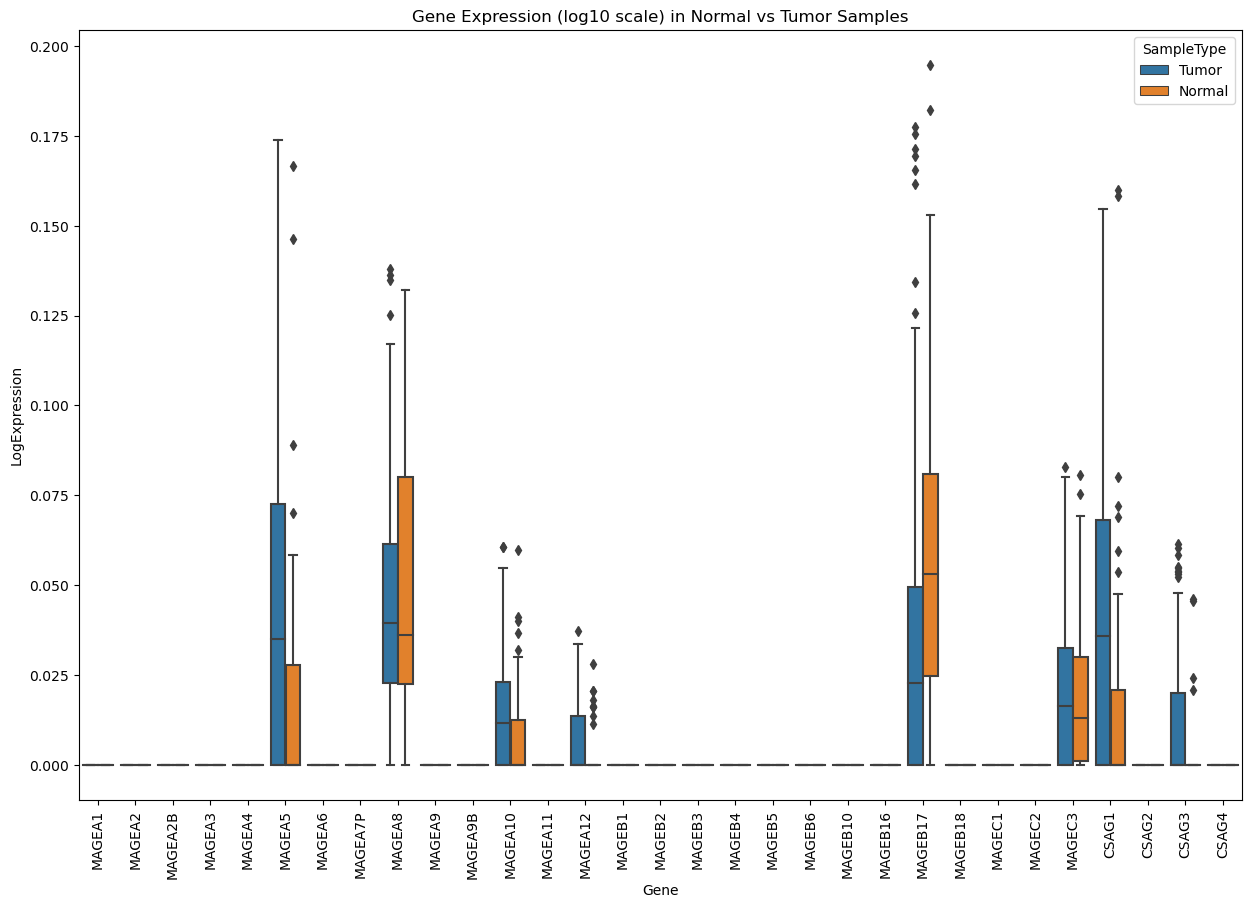

In [17]:
# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each gene separately
cleaned_df = combined_df.groupby('Gene').apply(lambda x: remove_outliers(x, 'LogExpression')).reset_index(drop=True)
cleaned_df.to_csv(os.path.join(toData_directory, 'CombinedExpressionNormalvsTumor_NoOutliers.csv'))

# Create boxplots with cleaned data and specified order
plt.figure(figsize=(15, 10))
sns.boxplot(data=cleaned_df, x='Gene', y='LogExpression', hue='SampleType', order=Type1)
plt.xticks(rotation=90)
plt.title('Gene Expression (log10 scale) in Normal vs Tumor Samples')
plt.savefig(os.path.join(toPlots_directory, 'type1_ExpressionNormalTumorNoOutliers_histogram.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=4>2.2. Composition of Positive and Negative Tumors by MAGEs.</font></h1>

In [ ]:
#toData_directory="C:240503_TCGA_CPTAC-3_Output/240503_TCGA_CPTAC-3_Overview/240503_TCGA_CPTAC-3_Data/"

In [18]:
no_zero = df_numeric.astype(bool).sum(axis=0)
zero = df_numeric.shape[0] - no_zero
# New df to order output
output_df = pd.DataFrame({'Positive_counts': no_zero, 'Negative_counts': zero})
output_df['Total_counts'] = output_df['Positive_counts'] + output_df['Negative_counts']
# Calculate percentages
percentage_df = output_df[['Positive_counts', 'Negative_counts']].div(output_df['Total_counts'], axis=0) * 100
# Concatenate percentages with original DataFrame
output_df = pd.concat([output_df, percentage_df.add_suffix('_percentage')], axis=1)
# Sort DataFrame by column names (alphabetical order)
output_df = output_df.sort_index()
finalTable= output_df[['Positive_counts','Positive_counts_percentage','Negative_counts','Negative_counts_percentage']]
finalTable=finalTable.round(1)
finalTable=finalTable.loc[column_order]
finalTable.to_csv(os.path.join(toData_directory, 'MAGE_PosNeg_Composition.csv'))
finalTable.head(3)

Positive_counts  Positive_counts_percentage  Negative_counts  \
MAGEA1                33                        18.4              146   
MAGEA2                 4                         2.2              175   
MAGEA2B                2                         1.1              177   

         Negative_counts_percentage  
MAGEA1                         81.6  
MAGEA2                         97.8  
MAGEA2B                        98.9

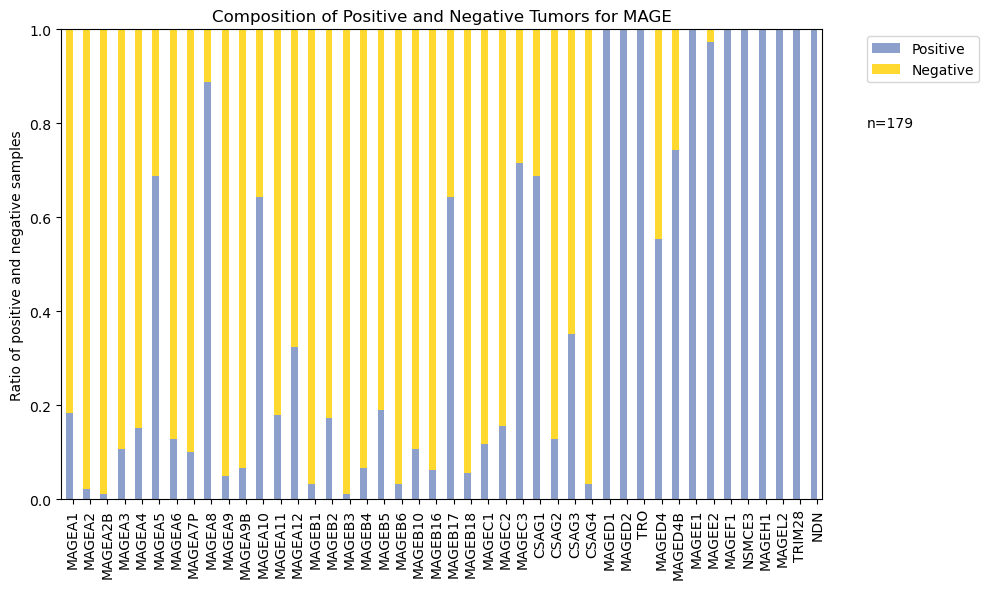

In [19]:
# Normalization
total_counts = no_zero + zero
if total_counts.nunique() == 1:  # Ensures all values are the same
    n = total_counts.iloc[0]
else:
    print("Not all values are the same.")

positive_normalized = no_zero / total_counts
positive_normalized= positive_normalized[column_order]
negative_normalized = zero / total_counts
negative_normalized= negative_normalized[column_order]
# Set colors
colors_pastel = sns.color_palette("Set2")
# Stacked barplot
plt.figure(figsize=(10, 6))
positive_normalized.plot(kind='bar', color=colors_pastel[2], width=0.4, position=1, label='Positive')
negative_normalized.plot(kind='bar', color=colors_pastel[5], width=0.4, position=1, bottom=positive_normalized, label='Negative')
plt.title('Composition of Positive and Negative Tumors for MAGE')
plt.ylabel('Ratio of positive and negative samples')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.text(1.09, 0.8, f'n={n}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=4>2.3. MAGEs expression vs Tumor Grade.</font></h1>

In [20]:
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df['tumor_grade'].dropna()
df['tumor_grade']

sample
C3L-00017-02    G2
C3L-00102-01    G3
C3L-00189-02    G2
C3L-00277-03    G2
C3L-00401-02    G2
                ..
C3N-04119-02    G2
C3N-04126-02    G3
C3N-04282-01    G3
C3N-04283-03    G3
C3N-04284-01    G3
Name: tumor_grade, Length: 179, dtype: object

In [21]:
# Ensure only columns in column_order plus 'tumor_grade' are considered
columns_to_use = column_order + ['tumor_grade']
df_filtered = df[columns_to_use]

# Create DataFrames for positive and negative counts
positive_counts = (df_filtered[column_order] > 0).astype(int)
negative_counts = (df_filtered[column_order] <= 0).astype(int)

# Add 'tumor_grade' to these DataFrames for grouping
positive_counts['tumor_grade'] = df_filtered['tumor_grade']
negative_counts['tumor_grade'] = df_filtered['tumor_grade']

# Group by 'tumor_grade' and sum the counts
grouped_positive_counts = positive_counts.groupby('tumor_grade').sum()
grouped_negative_counts = negative_counts.groupby('tumor_grade').sum()

# Rename columns to reflect positive and negative counts
grouped_positive_counts.columns = [f"{col}_positive" for col in grouped_positive_counts.columns]
grouped_negative_counts.columns = [f"{col}_negative" for col in grouped_negative_counts.columns]
final_counts = pd.concat([grouped_positive_counts, grouped_negative_counts], axis=1).reset_index()
melted_df = pd.melt(final_counts, id_vars=['tumor_grade'], var_name='gene_classification', value_name='count')
melted_df['gene'] = melted_df['gene_classification'].apply(lambda x: x.split('_')[0])
melted_df['classification'] = melted_df['gene_classification'].apply(lambda x: 'Positive' if 'positive' in x else 'Negative')
melted_df = melted_df.drop(columns=['gene_classification'])
# Pivot the DataFrame to get counts with tumor grades stacked per gene and classification
pivot_df = melted_df.pivot_table(
    index=['gene', 'classification'], 
    columns='tumor_grade', 
    values='count', 
    aggfunc='sum',
    fill_value=0
).reindex(pd.MultiIndex.from_product([column_order, ['Positive', 'Negative']], names=['gene', 'classification']), fill_value=0)

pivot_df.to_csv(os.path.join(toData_directory, 'MAGE_GRADE_PosNeg_Composition.csv'))


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


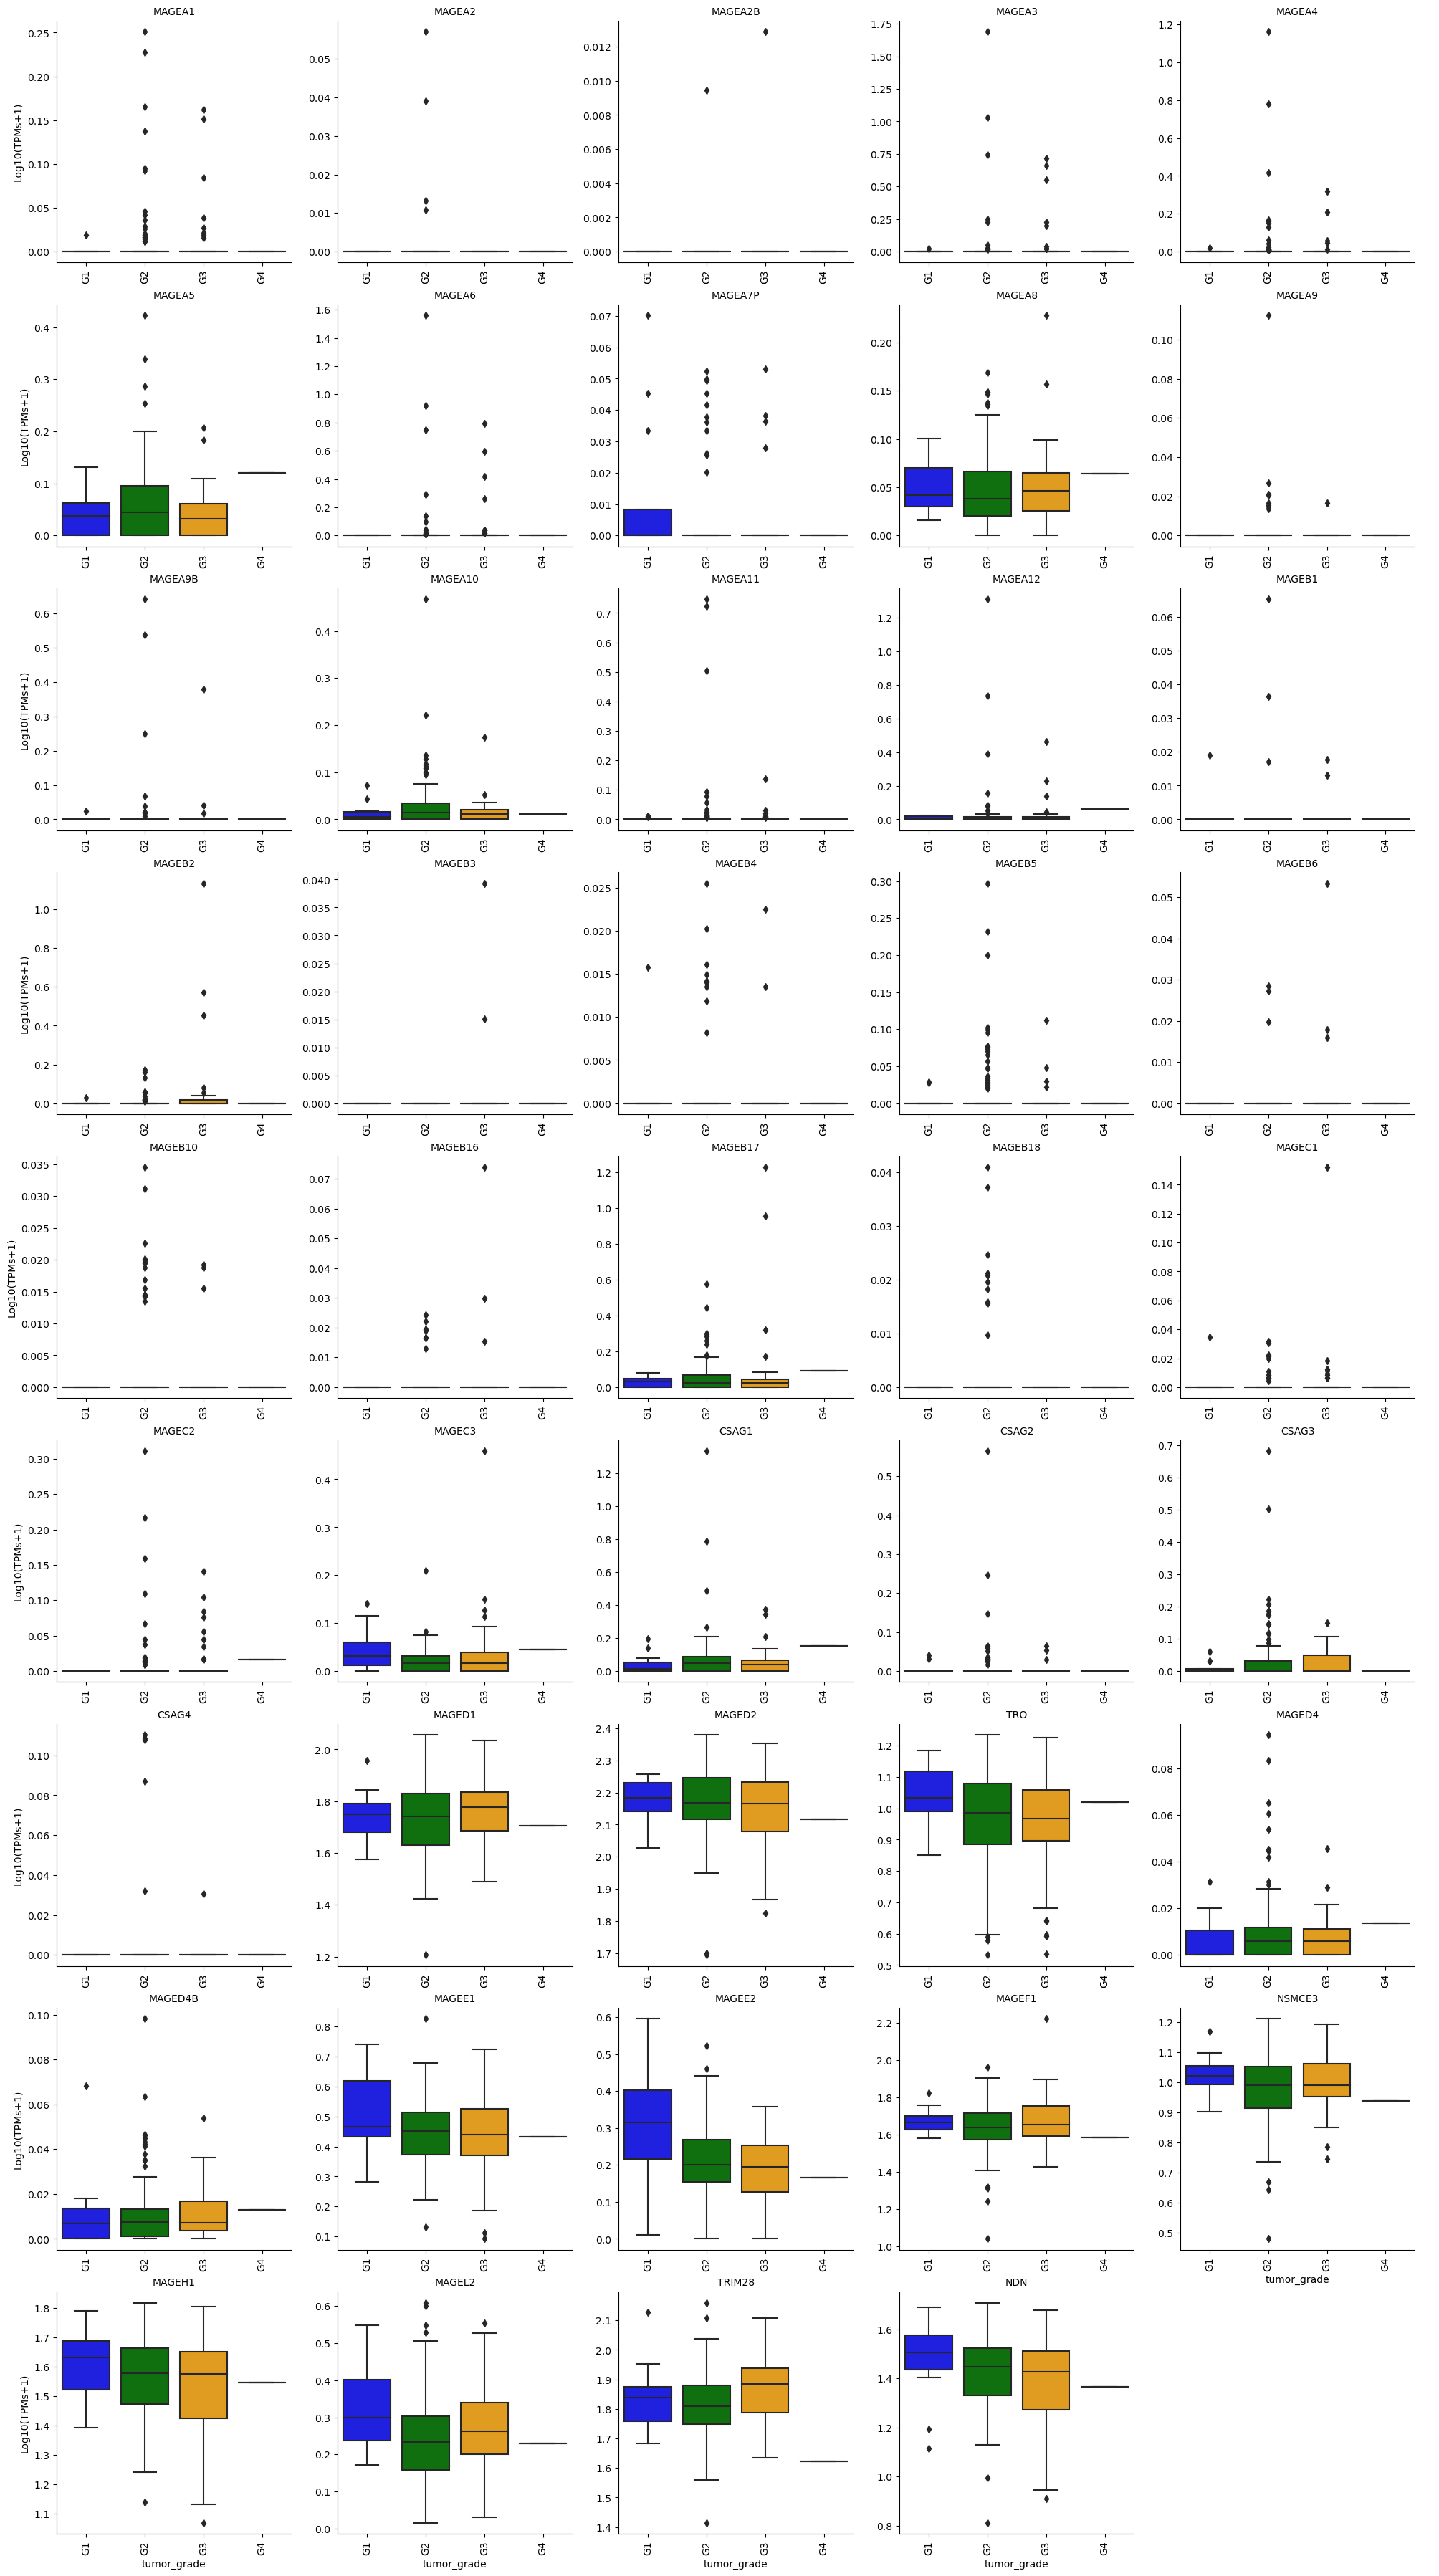

In [25]:
# Ensure the DataFrame contains only the columns in 'column_order' and in the specified order
df_filtered = df[column_order]

# Applying log transformation
df_log_transformed = np.log10(df_filtered + 1)

# Add 'tumor_grade' for grouping in the plot
df_log_transformed['tumor_grade'] = df['tumor_grade']

# Sorting tumor grades by predefined order
grade_order = ["G1", "G2", "G3", "G4"]
df_log_transformed['tumor_grade'] = pd.Categorical(df_log_transformed['tumor_grade'], categories=grade_order, ordered=True)

# Melting the DataFrame to long format for seaborn FacetGrid
df_long = df_log_transformed.melt(id_vars='tumor_grade', var_name='Gene', value_name='Log10(TPMs+1)')
excel_file_path = os.path.join(toData_directory, 'boxplot_data.xlsx')
df_long.to_excel(excel_file_path, index=False)

# Define a palette for tumor grades
palette = {
    "G1": "blue",
    "G2": "green",
    "G3": "orange",
    "G4": "red"}

# Creating the FacetGrid boxplot with individual y-axes and specific colors
g = sns.FacetGrid(df_long, col='Gene', col_wrap=5, height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.boxplot, x='tumor_grade', y='Log10(TPMs+1)', order=grade_order, palette=palette)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
g.add_legend()
plt.savefig(os.path.join(toPlots_directory, 'MAGE_GRADE_boxplot.png'), dpi=300)
plt.show()

In [23]:
data_grade= pd.read_csv('240520_TCGA_CPTAC-3_Output/240520_TCGA_CPTAC-3_Overview/240520_TCGA_CPTAC-3_Data/GradePercentage.csv', sep=',',index_col=0)

# Pivot the DataFrame to get the desired format
df_pivot = data_grade.pivot_table(index='gene', columns='classification', values=['G1%', 'G2%', 'G3%', 'G4%'])

# Flatten the MultiIndex columns
df_pivot.columns = [f'{grade}{class_type[0]}' for grade, class_type in df_pivot.columns]

# Reset the index to bring the 'gene' column back
df_pivot = df_pivot.reset_index()

# Reorder the DataFrame according to the specified gene order
df_pivot = df_pivot.set_index('gene').reindex(column_order).reset_index()

# Display the result
print(df_pivot)

df_pivot.to_csv(os.path.join(toData_directory, 'transformed_grade_percentage.csv'), index=False)


       gene  G1%N  G1%P   G2%N   G2%P   G3%N   G3%P  G4%N  G4%P
0    MAGEA1  6.18  0.56  57.87  12.92  17.42   5.06  0.56  0.00
1    MAGEA2  6.74  0.00  68.54   2.25  22.47   0.00  0.56  0.00
2   MAGEA2B  6.74  0.00  70.22   0.56  21.91   0.56  0.56  0.00
3    MAGEA3  6.18  0.56  65.17   5.62  17.98   4.49  0.56  0.00
4    MAGEA4  6.18  0.56  58.99  11.80  19.66   2.81  0.56  0.00
5    MAGEA5  2.81  3.93  20.79  50.00   7.87  14.61  0.00  0.56
6    MAGEA6  6.74  0.00  62.92   7.87  17.42   5.06  0.56  0.00
7   MAGEA7P  5.06  1.69  64.61   6.18  20.22   2.25  0.56  0.00
8    MAGEA8  0.00  6.74   8.43  62.36   2.81  19.66  0.00  0.56
9    MAGEA9  6.74  0.00  66.29   4.49  21.91   0.56  0.56  0.00
10  MAGEA9B  6.18  0.56  66.29   4.49  20.79   1.69  0.56  0.00
11  MAGEA10  3.37  3.37  23.03  47.75   9.55  12.92  0.00  0.56
12  MAGEA11  5.06  1.69  58.99  11.80  17.98   4.49  0.56  0.00
13  MAGEA12  3.37  3.37  51.12  19.66  13.48   8.99  0.00  0.56
14   MAGEB1  6.18  0.56  69.10   1.69  2

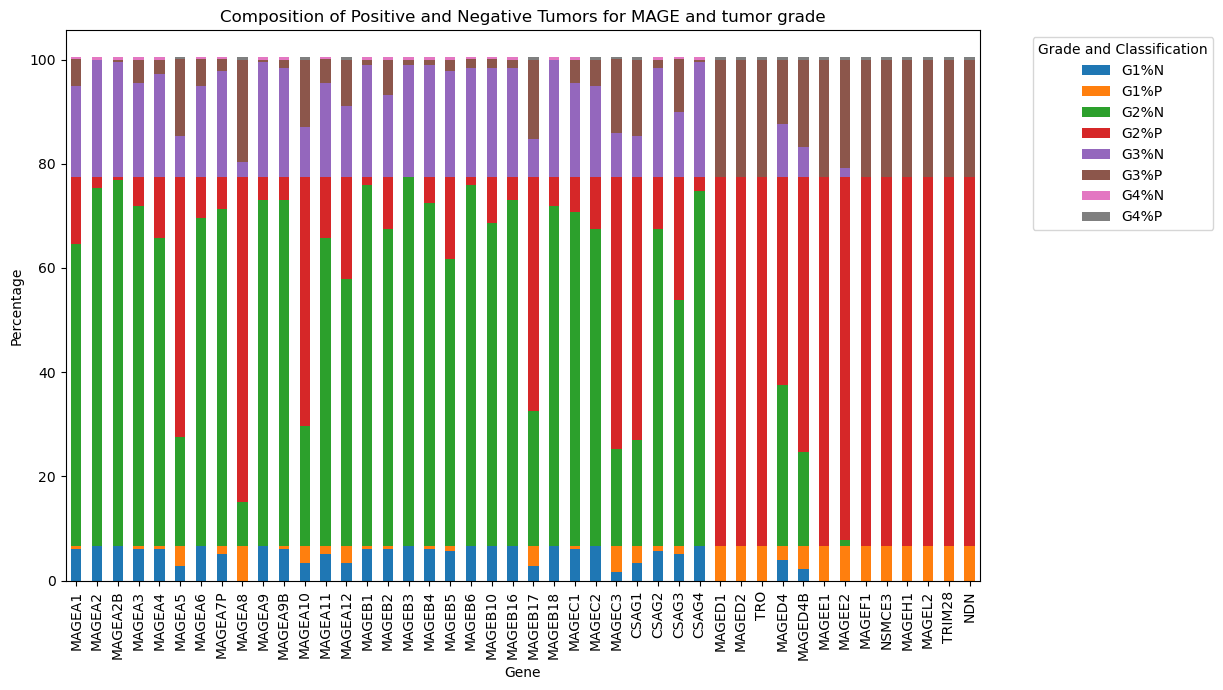

In [24]:
# Plot the stacked bar plot
df_pivot.set_index('gene').plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Composition of Positive and Negative Tumors for MAGE and tumor grade')
plt.xlabel('Gene')
plt.ylabel('Percentage')
plt.legend(title='Grade and Classification')
plt.xticks(rotation=90)
plt.tight_layout()
# Place the legend outside the plot
plt.legend(title='Grade and Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(toPlots_directory, 'MAGE_GRADE_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=4>2.4. MAGEs expression vs Sex.</font></h1>

In [26]:
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df['gender'].dropna()
df['gender']

sample
C3L-00017-02      male
C3L-00102-01      male
C3L-00189-02    female
C3L-00277-03      male
C3L-00401-02    female
                 ...  
C3N-04119-02      male
C3N-04126-02      male
C3N-04282-01      male
C3N-04283-03    female
C3N-04284-01    female
Name: gender, Length: 179, dtype: object

In [27]:
# Ensure only columns in column_order plus 'tumor_grade' are considered
columns_to_use = column_order + ['gender']
df_filtered = df[columns_to_use]

# Create DataFrames for positive and negative counts
positive_counts = (df_filtered[column_order] > 0).astype(int)
negative_counts = (df_filtered[column_order] <= 0).astype(int)

# Add 'tumor_grade' to these DataFrames for grouping
positive_counts['gender'] = df_filtered['gender']
negative_counts['gender'] = df_filtered['gender']

# Group by 'tumor_grade' and sum the counts
grouped_positive_counts = positive_counts.groupby('gender').sum()
grouped_negative_counts = negative_counts.groupby('gender').sum()

# Rename columns to reflect positive and negative counts
grouped_positive_counts.columns = [f"{col}_positive" for col in grouped_positive_counts.columns]
grouped_negative_counts.columns = [f"{col}_negative" for col in grouped_negative_counts.columns]
final_counts = pd.concat([grouped_positive_counts, grouped_negative_counts], axis=1).reset_index()
melted_df = pd.melt(final_counts, id_vars=['gender'], var_name='gene_classification', value_name='count')
melted_df['gene'] = melted_df['gene_classification'].apply(lambda x: x.split('_')[0])
melted_df['classification'] = melted_df['gene_classification'].apply(lambda x: 'Positive' if 'positive' in x else 'Negative')
melted_df = melted_df.drop(columns=['gene_classification'])
# Pivot the DataFrame to get counts with tumor grades stacked per gene and classification
pivot_df = melted_df.pivot_table(
    index=['gene', 'classification'], 
    columns='gender', 
    values='count', 
    aggfunc='sum',
    fill_value=0
).reindex(pd.MultiIndex.from_product([column_order, ['Positive', 'Negative']], names=['gene', 'classification']), fill_value=0)

pivot_df.to_csv(os.path.join(toData_directory, 'MAGE_SEX_PosNeg_Composition.csv'))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


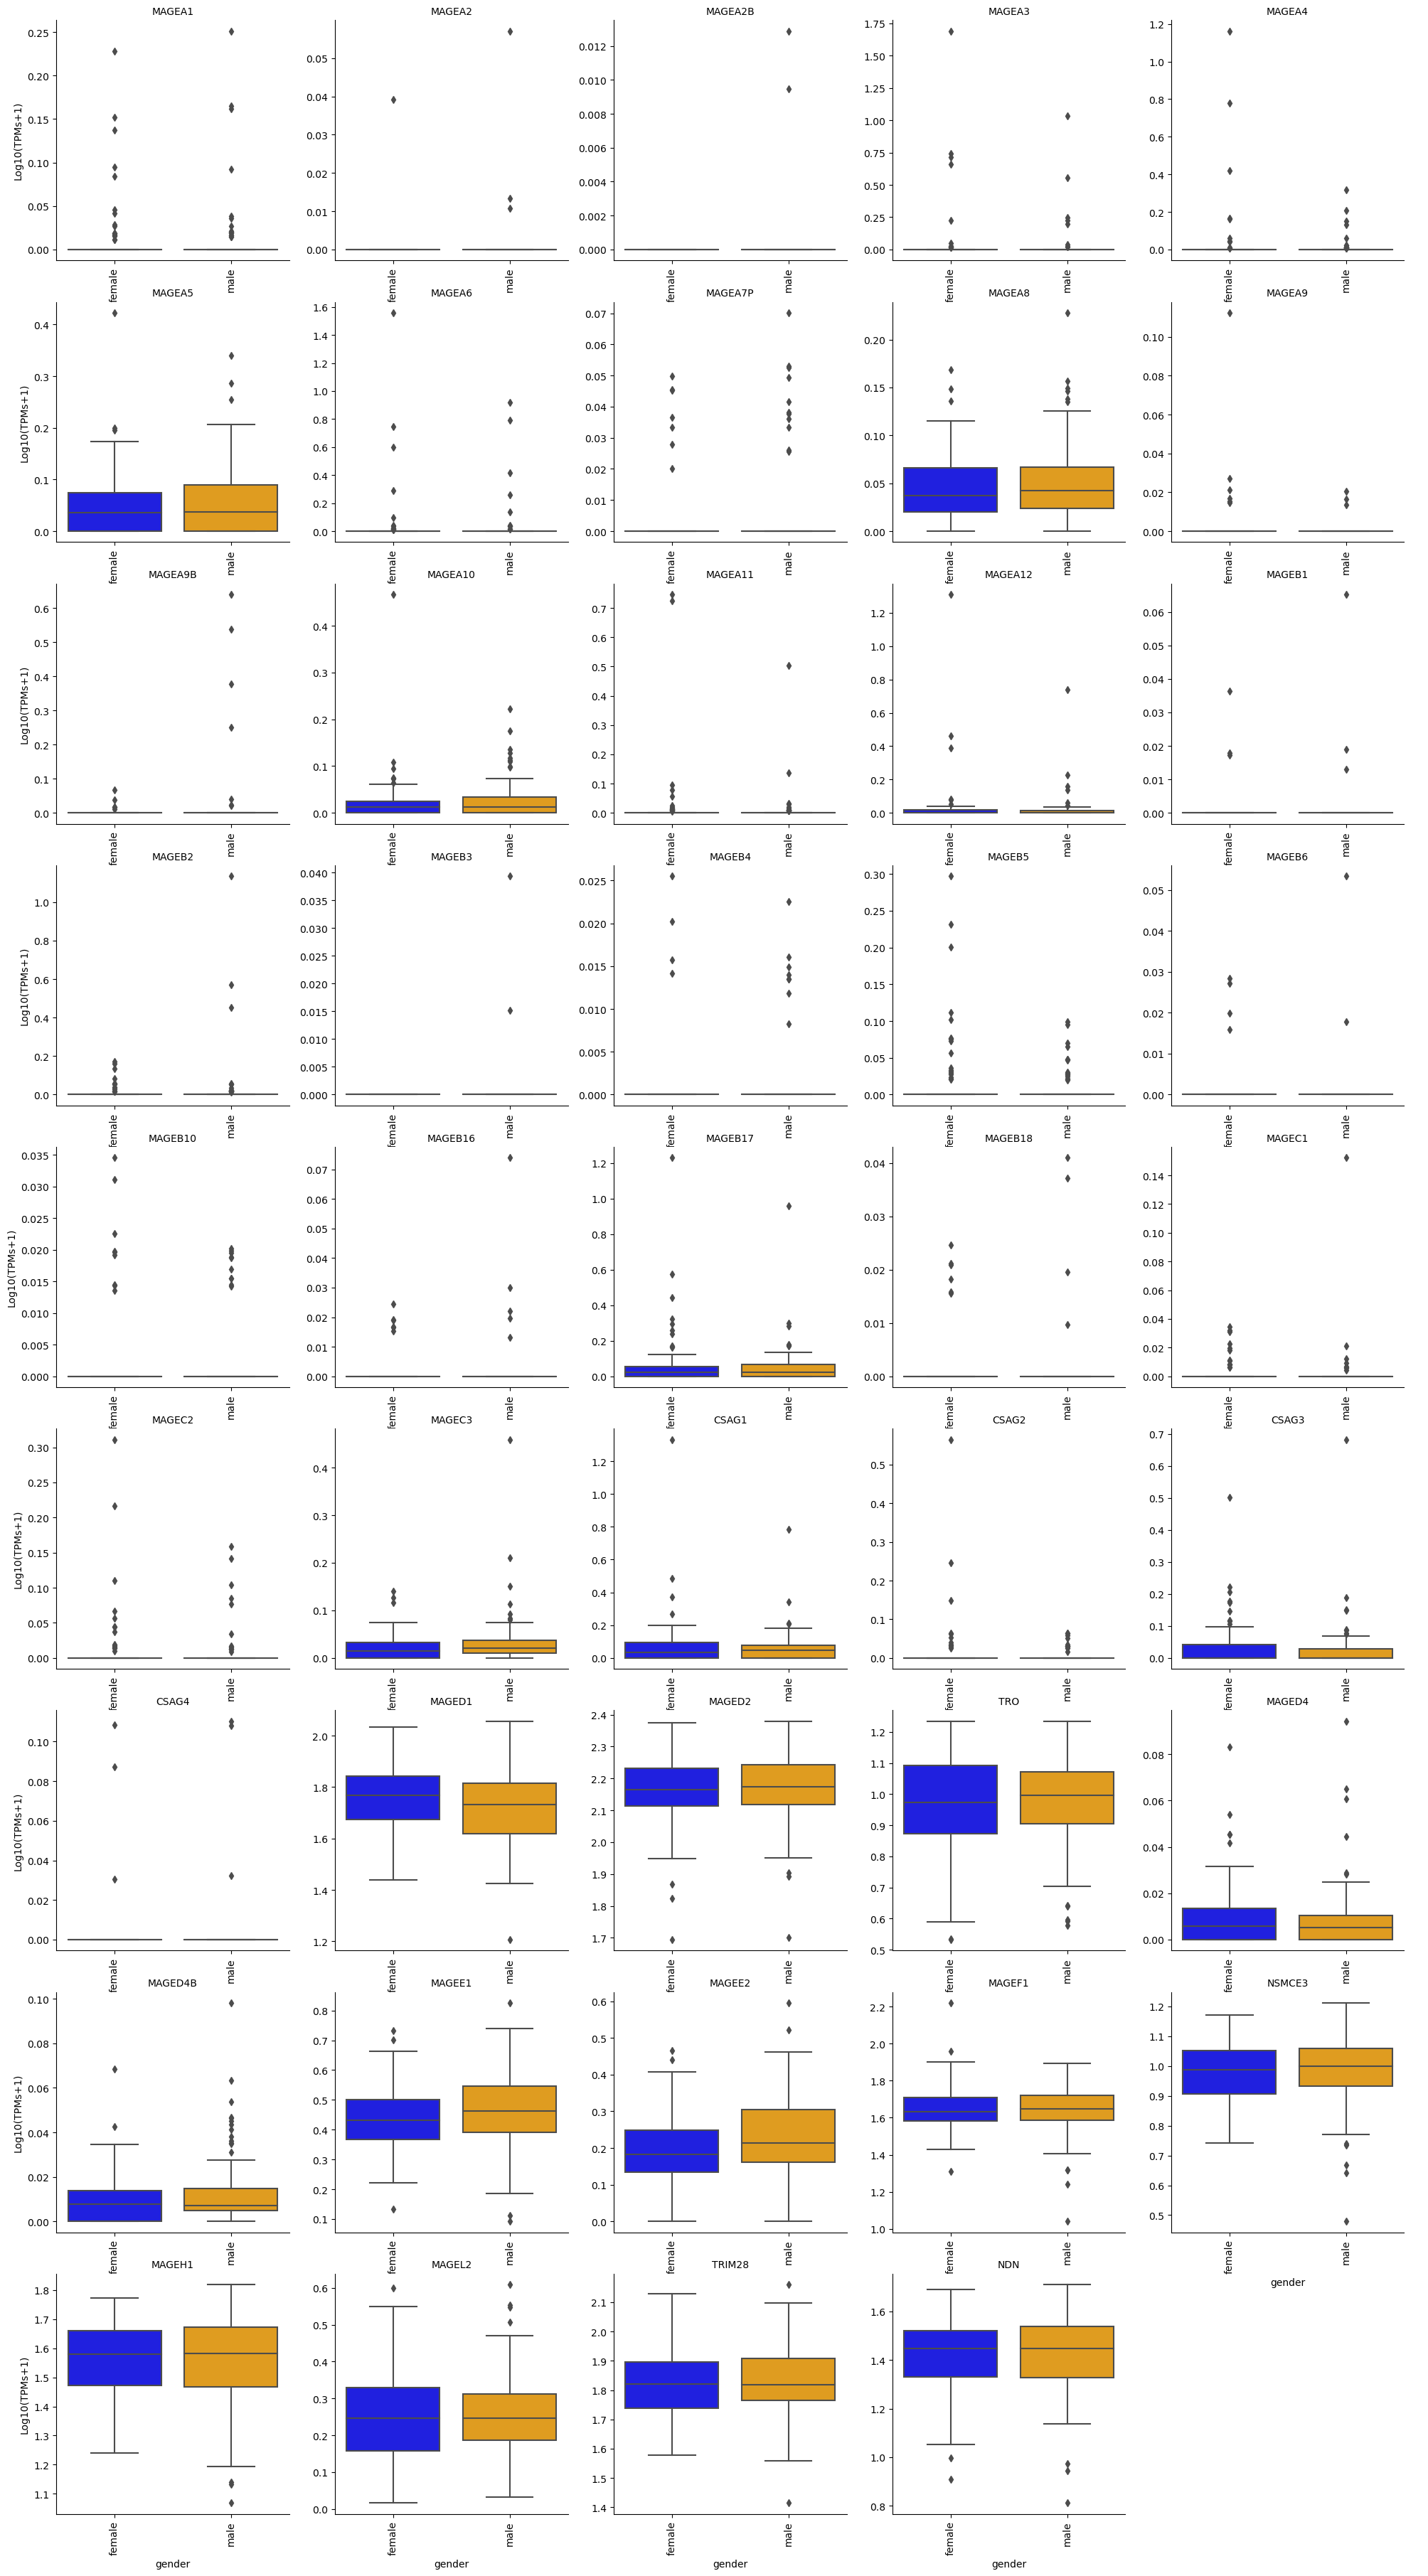

In [28]:
# Ensure the DataFrame contains only the columns in 'column_order' and in the specified order
df_filtered = df[column_order]

# Applying log transformation
df_log_transformed = np.log10(df_filtered + 1)

# Add 'tumor_grade' for grouping in the plot
df_log_transformed['gender'] = df['gender']

# Sorting tumor grades by predefined order
grade_order = ["female", "male"]
df_log_transformed['gender'] = pd.Categorical(df_log_transformed['gender'], categories=grade_order, ordered=True)

# Melting the DataFrame to long format for seaborn FacetGrid
df_long = df_log_transformed.melt(id_vars='gender', var_name='Gene', value_name='Log10(TPMs+1)')
excel_file_path = os.path.join(toData_directory, 'boxplot_data_Sex.xlsx')
df_long.to_excel(excel_file_path, index=False)

# Define a palette for tumor grades
palette = {
    "female": "blue",
    "male": "orange"}

# Creating the FacetGrid boxplot with individual y-axes and specific colors
g = sns.FacetGrid(df_long, col='Gene', col_wrap=5, height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.boxplot, x='gender', y='Log10(TPMs+1)', order=grade_order, palette=palette)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
g.add_legend()
plt.savefig(os.path.join(toPlots_directory, 'MAGE_SEX_boxplot.png'), dpi=300)
plt.show()

In [30]:
data_grade= pd.read_csv('240520_TCGA_CPTAC-3_Output/240520_TCGA_CPTAC-3_Overview/240520_TCGA_CPTAC-3_Data/SexPercentage.csv', sep=',',index_col=0)

# Pivot the DataFrame to get the desired format
df_pivot = data_grade.pivot_table(index='gene', columns='classification', values=['female%', 'male%'])

# Flatten the MultiIndex columns
df_pivot.columns = [f'{grade}{class_type[0]}' for grade, class_type in df_pivot.columns]

# Reset the index to bring the 'gene' column back
df_pivot = df_pivot.reset_index()

# Reorder the DataFrame according to the specified gene order
df_pivot = df_pivot.set_index('gene').reindex(column_order).reset_index()

# Display the result
print(df_pivot)

df_pivot.to_csv(os.path.join(toData_directory, 'transformed_sex_percentage.csv'), index=False)


       gene  female%N  female%P  male%N  male%P
0    MAGEA1     36.31      9.50   45.25    8.94
1    MAGEA2     45.25      0.56   52.51    1.68
2   MAGEA2B     45.81      0.00   53.07    1.12
3    MAGEA3     39.66      6.15   49.72    4.47
4    MAGEA4     39.66      6.15   45.25    8.94
5    MAGEA5     14.53     31.28   16.76   37.43
6    MAGEA6     38.55      7.26   48.60    5.59
7   MAGEA7P     41.90      3.91   48.04    6.15
8    MAGEA8      6.15     39.66    5.03   49.16
9    MAGEA9     42.46      3.35   52.51    1.68
10  MAGEA9B     43.02      2.79   50.28    3.91
11  MAGEA10     16.20     29.61   19.55   34.64
12  MAGEA11     36.31      9.50   45.81    8.38
13  MAGEA12     31.28     14.53   36.31   17.88
14   MAGEB1     44.13      1.68   52.51    1.68
15   MAGEB2     38.55      7.26   44.13   10.06
16   MAGEB3     45.81      0.00   53.07    1.12
17   MAGEB4     43.58      2.23   49.72    4.47
18   MAGEB5     35.75     10.06   45.25    8.94
19   MAGEB6     43.58      2.23   53.07 

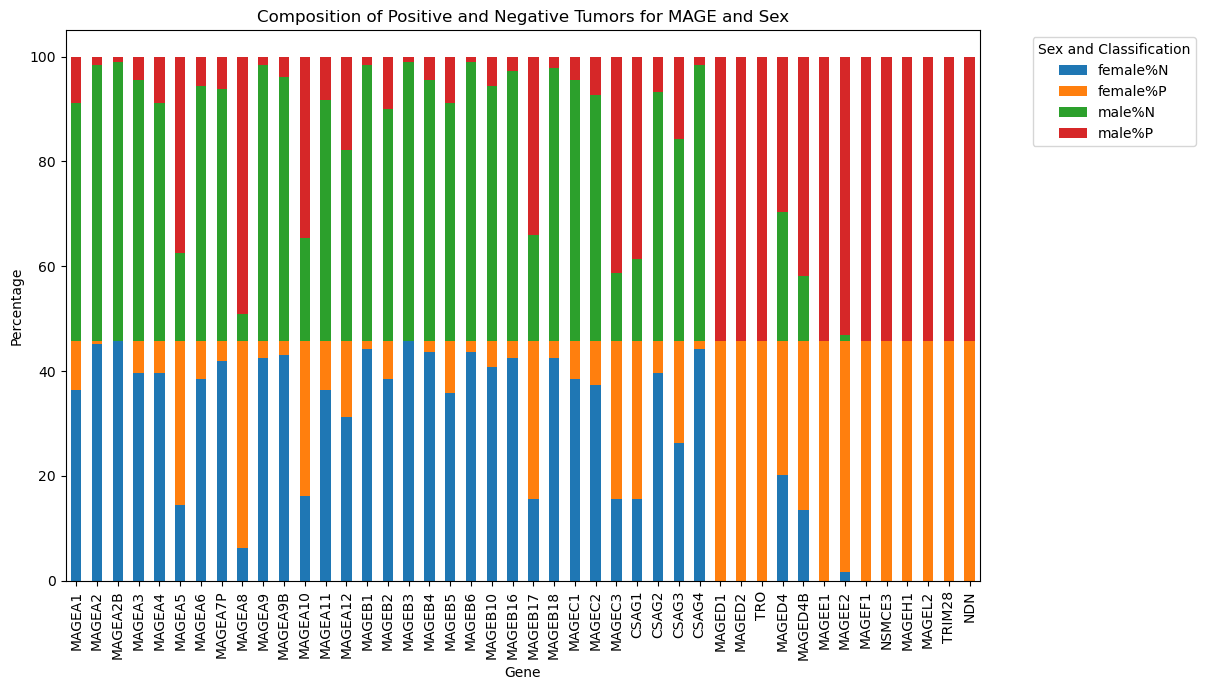

In [31]:
# Plot the stacked bar plot
df_pivot.set_index('gene').plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Composition of Positive and Negative Tumors for MAGE and Sex')
plt.xlabel('Gene')
plt.ylabel('Percentage')
plt.legend(title='Sex and Classification')
plt.xticks(rotation=90)
plt.tight_layout()
# Place the legend outside the plot
plt.legend(title='Sex and Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(toPlots_directory, 'MAGE_SEX_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=4>2.5. MAGEs expression vs Age.</font></h1>

In [32]:
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df['days_to_birth'].dropna(inplace=True)
df['days_to_birth'] = pd.to_numeric(df['days_to_birth'], errors='coerce')
df.dropna(subset=['days_to_birth'], inplace=True)
df['days_to_birth']

sample
C3L-00017-02   -25349.0
C3L-00102-01   -15616.0
C3L-00189-02   -24958.0
C3L-00277-03   -25515.0
C3L-00401-02   -22991.0
                 ...   
C3N-04119-02   -19826.0
C3N-04126-02   -15708.0
C3N-04282-01   -27699.0
C3N-04283-03   -24187.0
C3N-04284-01   -29323.0
Name: days_to_birth, Length: 177, dtype: float64

In [33]:
df['age'] = ((df['days_to_birth'] * -1) / 365.25).astype(int)
df['age']

C:\Users\TTUSVM\AppData\Local\Temp\ipykernel_5688\5356115.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['age'] = ((df['days_to_birth'] * -1) / 365.25).astype(int)


sample
C3L-00017-02    69
C3L-00102-01    42
C3L-00189-02    68
C3L-00277-03    69
C3L-00401-02    62
                ..
C3N-04119-02    54
C3N-04126-02    43
C3N-04282-01    75
C3N-04283-03    66
C3N-04284-01    80
Name: age, Length: 177, dtype: int32

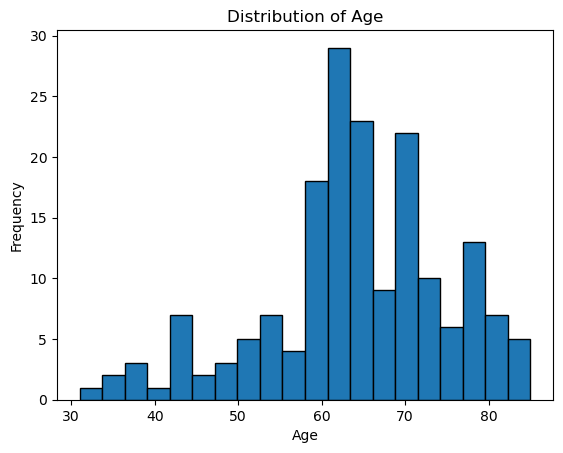

In [34]:
df['age'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [35]:
bins = [0, 20, 40, 60, 70, 80, 90, 100]
labels = ['Child','Young', 'Senior-40', 'Senior-60','Senior-70','Elderly-80', 'Elderly-90']
# Create custom bins
df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['age_category'].value_counts()

C:\Users\TTUSVM\AppData\Local\Temp\ipykernel_5688\2913220166.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


age_category
Senior-60     83
Senior-70     39
Senior-40     37
Elderly-80    12
Young          6
Child          0
Elderly-90     0
Name: count, dtype: int64

In [36]:
# Ensure only columns in column_order plus 'tumor_grade' are considered
columns_to_use = column_order + ['age_category']
df_filtered = df[columns_to_use]

# Create DataFrames for positive and negative counts
positive_counts = (df_filtered[column_order] > 0).astype(int)
negative_counts = (df_filtered[column_order] <= 0).astype(int)

# Add 'tumor_grade' to these DataFrames for grouping
positive_counts['age_category'] = df_filtered['age_category']
negative_counts['age_category'] = df_filtered['age_category']

# Group by 'tumor_grade' and sum the counts
grouped_positive_counts = positive_counts.groupby('age_category').sum()
grouped_negative_counts = negative_counts.groupby('age_category').sum()

# Rename columns to reflect positive and negative counts
grouped_positive_counts.columns = [f"{col}_positive" for col in grouped_positive_counts.columns]
grouped_negative_counts.columns = [f"{col}_negative" for col in grouped_negative_counts.columns]
final_counts = pd.concat([grouped_positive_counts, grouped_negative_counts], axis=1).reset_index()
melted_df = pd.melt(final_counts, id_vars=['age_category'], var_name='gene_classification', value_name='count')
melted_df['gene'] = melted_df['gene_classification'].apply(lambda x: x.split('_')[0])
melted_df['classification'] = melted_df['gene_classification'].apply(lambda x: 'Positive' if 'positive' in x else 'Negative')
melted_df = melted_df.drop(columns=['gene_classification'])
# Pivot the DataFrame to get counts with tumor grades stacked per gene and classification
pivot_df = melted_df.pivot_table(
    index=['gene', 'classification'], 
    columns='age_category', 
    values='count', 
    aggfunc='sum',
    fill_value=0
).reindex(pd.MultiIndex.from_product([column_order, ['Positive', 'Negative']], names=['gene', 'classification']), fill_value=0)

pivot_df.to_csv(os.path.join(toData_directory, 'MAGE_AGE_PosNeg_Composition.csv'))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


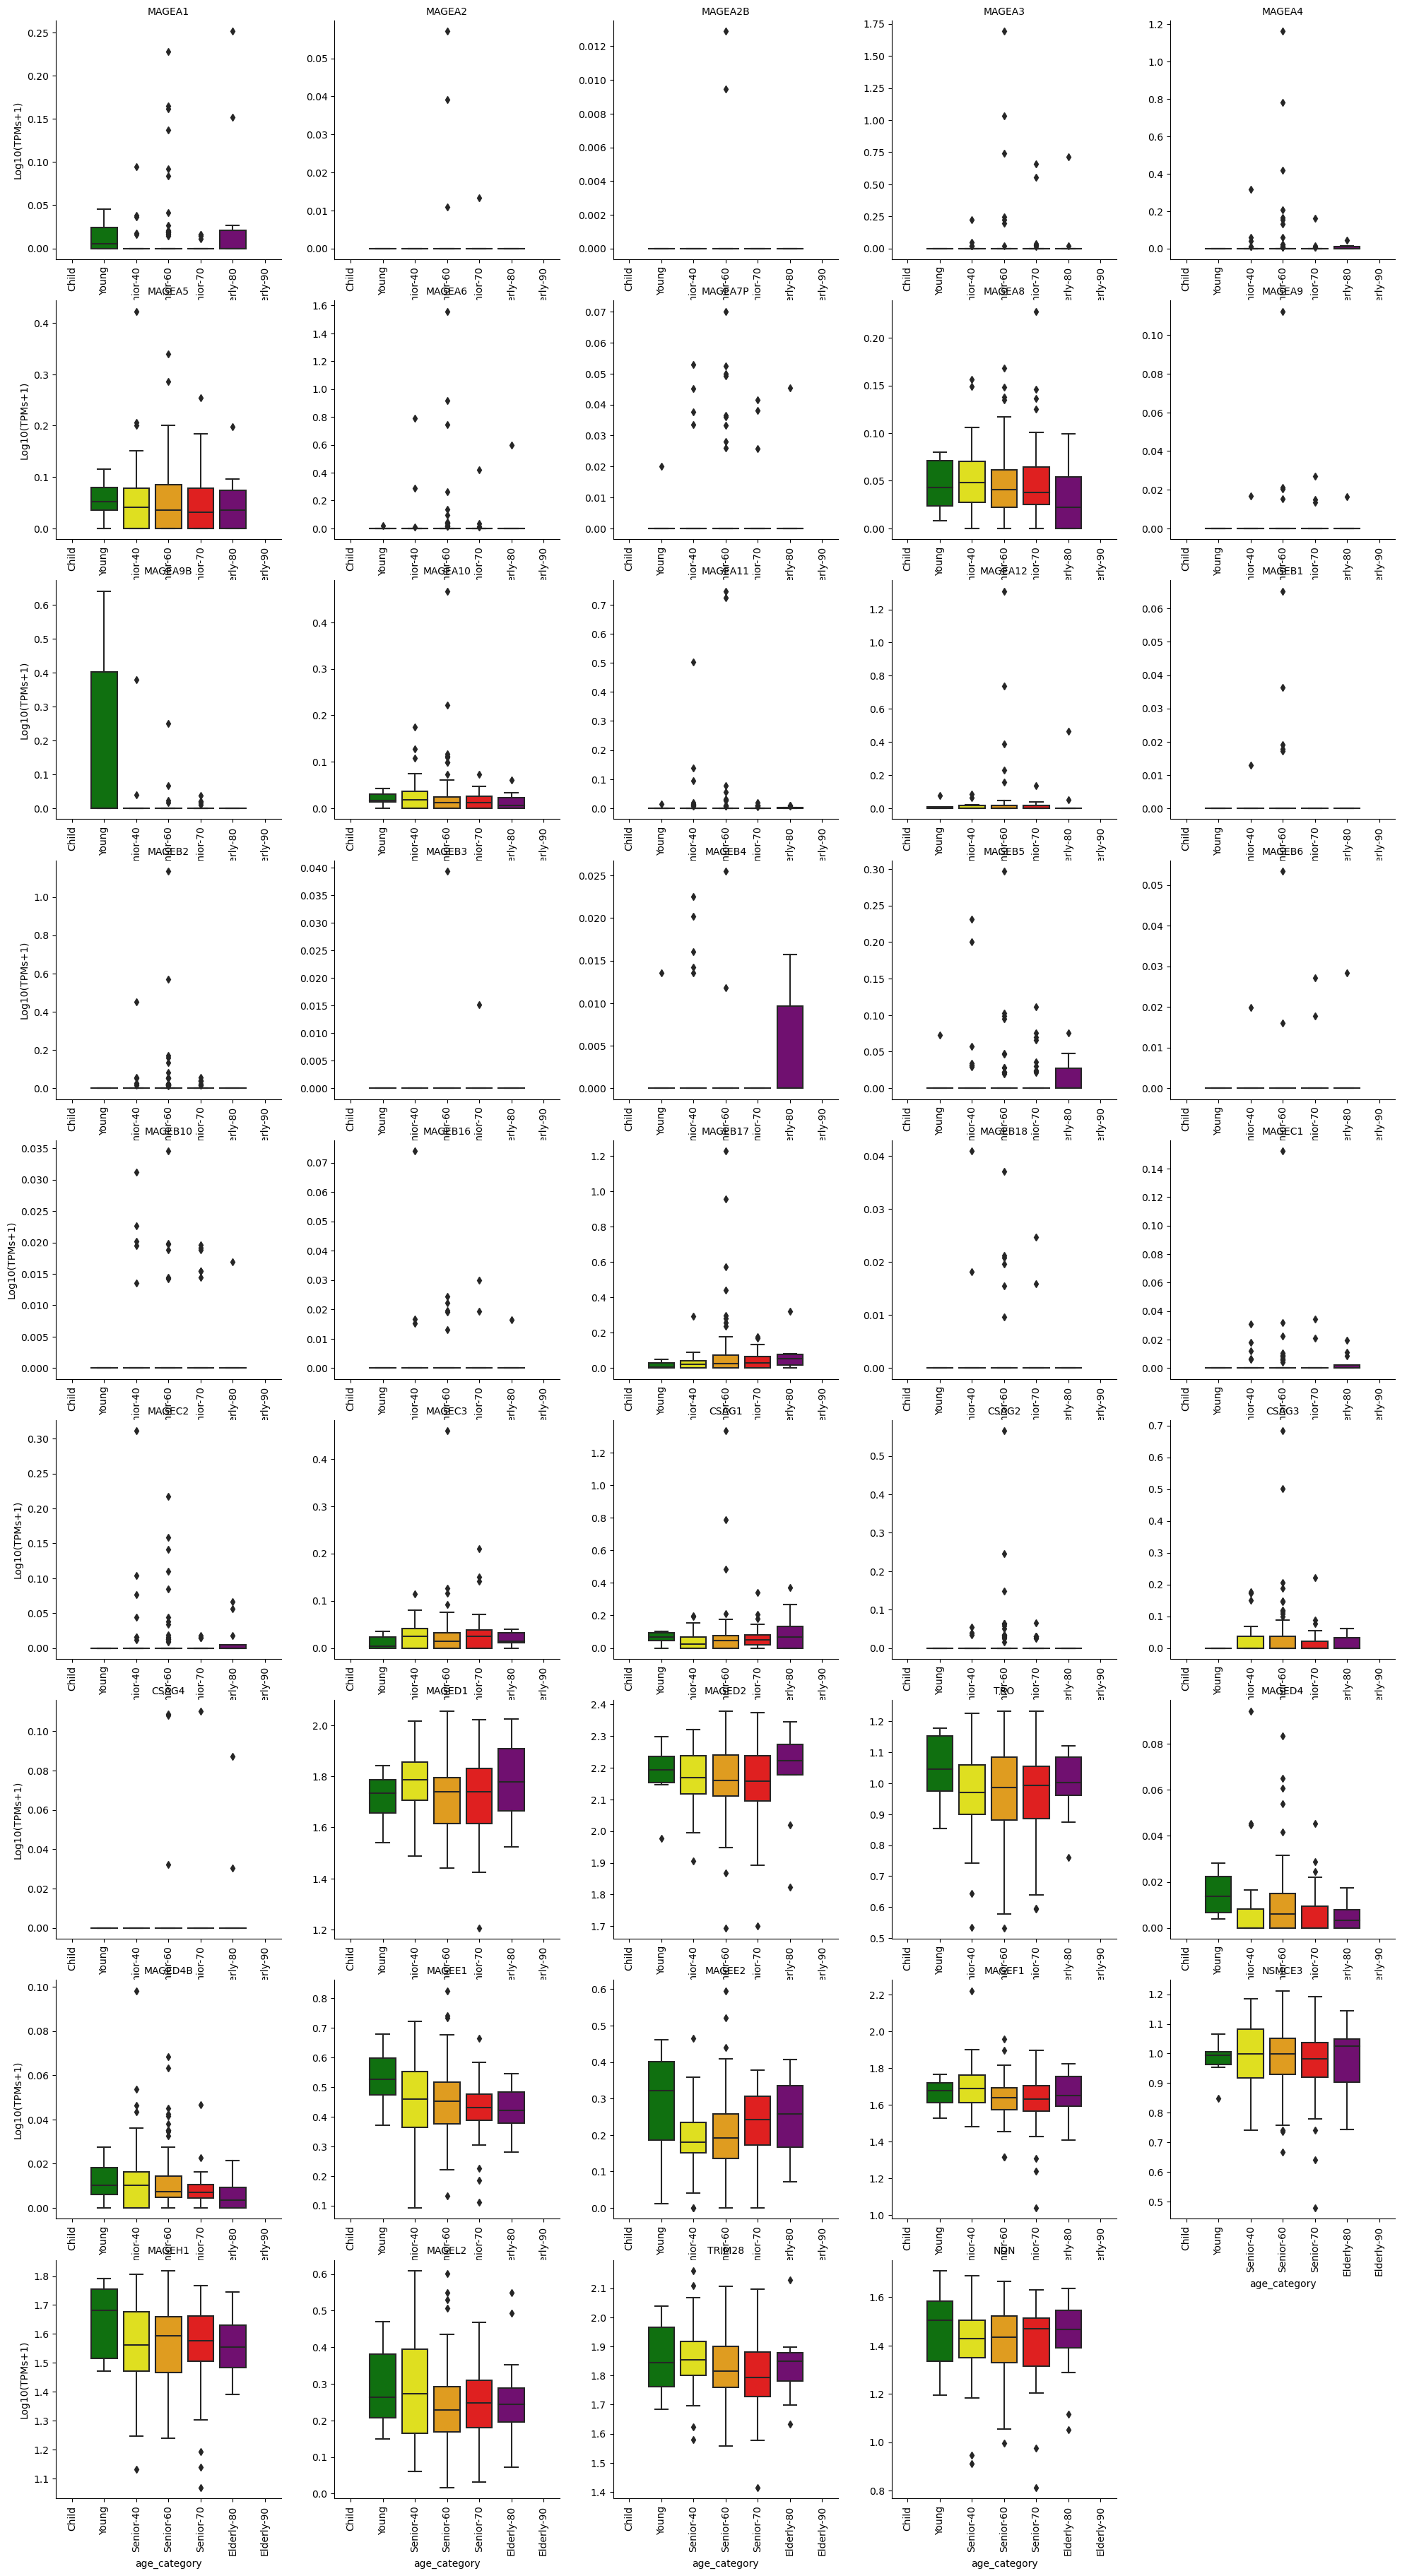

In [37]:
# Ensure the DataFrame contains only the columns in 'column_order' and in the specified order
df_filtered = df[column_order]

# Applying log transformation
df_log_transformed = np.log10(df_filtered + 1)

# Add 'tumor_grade' for grouping in the plot
df_log_transformed['age_category'] = df['age_category']

# Sorting tumor grades by predefined order
grade_order = ["Child", "Young","Senior-40","Senior-60", "Senior-70", "Elderly-80", "Elderly-90" ]
df_log_transformed['age_category'] = pd.Categorical(df_log_transformed['age_category'], categories=grade_order, ordered=True)

# Melting the DataFrame to long format for seaborn FacetGrid
df_long = df_log_transformed.melt(id_vars='age_category', var_name='Gene', value_name='Log10(TPMs+1)')
excel_file_path = os.path.join(toData_directory, 'boxplot_data_Sex.xlsx')
df_long.to_excel(excel_file_path, index=False)

# Define a palette for tumor
palette = {
    "Child": "lightblue",
    "Young": "green",
    "Senior-40": "yellow",
    "Senior-60": "orange",
    "Senior-70": "red",
    "Elderly-80": "purple",
    "Elderly-90": "brown"
}

# Creating the FacetGrid boxplot with individual y-axes and specific colors
g = sns.FacetGrid(df_long, col='Gene', col_wrap=5, height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.boxplot, x='age_category', y='Log10(TPMs+1)', order=grade_order, palette=palette)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
g.add_legend()
g.savefig(os.path.join(toPlots_directory, 'MAGE_AGE_boxplot.png'), dpi=300)
plt.show()

In [38]:
data_grade= pd.read_csv('240520_TCGA_CPTAC-3_Output/240520_TCGA_CPTAC-3_Overview/240520_TCGA_CPTAC-3_Data/AgePercentage.csv', sep=',',index_col=0)

# Pivot the DataFrame to get the desired format
df_pivot = data_grade.pivot_table(index='gene', columns='classification', values=['Child', 'Young','Senior-40','Senior-60', 'Senior-70', 'Elderly-80', 'Elderly-90'])

# Flatten the MultiIndex columns
df_pivot.columns = [f'{grade}{class_type[0]}' for grade, class_type in df_pivot.columns]

# Reset the index to bring the 'gene' column back
df_pivot = df_pivot.reset_index()

# Reorder the DataFrame according to the specified gene order
df_pivot = df_pivot.set_index('gene').reindex(column_order).reset_index()

# Display the result
print(df_pivot)

df_pivot.to_csv(os.path.join(toData_directory, 'transformed_age_percentage.csv'), index=False)


       gene  ChildN  ChildP  Elderly-80N  Elderly-80P  Elderly-90N  \
0    MAGEA1       0       0     3.954802     2.824859            0   
1    MAGEA2       0       0     6.779661     0.000000            0   
2   MAGEA2B       0       0     6.779661     0.000000            0   
3    MAGEA3       0       0     5.649718     1.129944            0   
4    MAGEA4       0       0     4.519774     2.259887            0   
5    MAGEA5       0       0     2.259887     4.519774            0   
6    MAGEA6       0       0     6.214689     0.564972            0   
7   MAGEA7P       0       0     6.214689     0.564972            0   
8    MAGEA8       0       0     2.259887     4.519774            0   
9    MAGEA9       0       0     6.214689     0.564972            0   
10  MAGEA9B       0       0     6.779661     0.000000            0   
11  MAGEA10       0       0     3.389831     3.389831            0   
12  MAGEA11       0       0     5.084746     1.694915            0   
13  MAGEA12       0 

In [39]:
print(df_pivot.columns)

Index(['gene', 'ChildN', 'ChildP', 'Elderly-80N', 'Elderly-80P', 'Elderly-90N',
       'Elderly-90P', 'Senior-40N', 'Senior-40P', 'Senior-60N', 'Senior-60P',
       'Senior-70N', 'Senior-70P', 'YoungN', 'YoungP'],
      dtype='object')


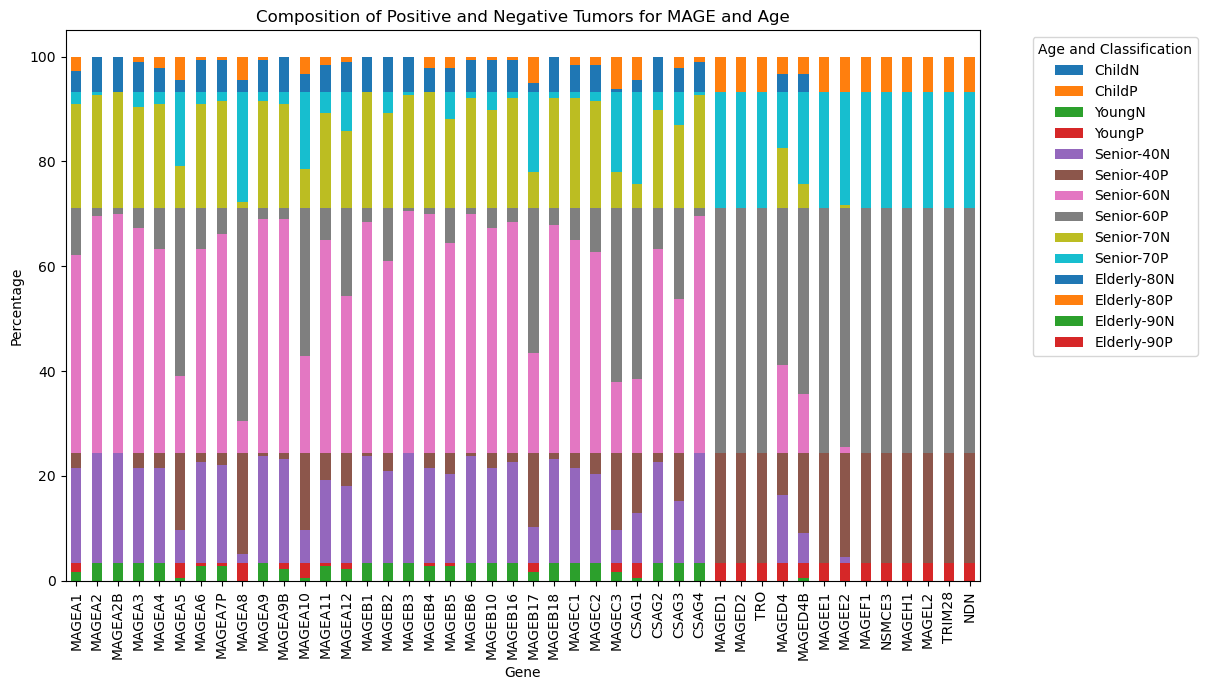

In [40]:
grade_order = ['gene','ChildN', 'ChildP', 'YoungN', 'YoungP', 'Senior-40N', 'Senior-40P',  'Senior-60N', 'Senior-60P', 'Senior-70N', 'Senior-70P', 
               'Elderly-80N', 'Elderly-80P', 'Elderly-90N','Elderly-90P']
# Plot the stacked bar plot
df_pivot = df_pivot[grade_order]
df_pivot.set_index('gene').plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Composition of Positive and Negative Tumors for MAGE and Age')
plt.xlabel('Gene')
plt.ylabel('Percentage')
plt.legend(title='Age and Classification')
plt.xticks(rotation=90)
plt.tight_layout()
# Place the legend outside the plot
plt.legend(title='Age and Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(toPlots_directory, 'MAGE_AGE_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=4>2.6. MAGEs expression vs Stage.</font></h1>

In [41]:
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df['ajcc_pathologic_stage'].dropna(inplace=True)
df['ajcc_pathologic_stage'].value_counts()

ajcc_pathologic_stage
Stage IIB     74
Stage III     49
Stage IIA     19
Stage IB      16
Stage IV      14
Stage IA       3
Stage IIIB     1
Stage I        1
Name: count, dtype: int64

In [42]:
# Ensure only columns in column_order plus 'tumor_grade' are considered
columns_to_use = column_order + ['ajcc_pathologic_stage']
df_filtered = df[columns_to_use]

# Create DataFrames for positive and negative counts
positive_counts = (df_filtered[column_order] > 0).astype(int)
negative_counts = (df_filtered[column_order] <= 0).astype(int)

# Add 'tumor_grade' to these DataFrames for grouping
positive_counts['ajcc_pathologic_stage'] = df_filtered['ajcc_pathologic_stage']
negative_counts['ajcc_pathologic_stage'] = df_filtered['ajcc_pathologic_stage']

# Group by 'tumor_grade' and sum the counts
grouped_positive_counts = positive_counts.groupby('ajcc_pathologic_stage').sum()
grouped_negative_counts = negative_counts.groupby('ajcc_pathologic_stage').sum()

# Rename columns to reflect positive and negative counts
grouped_positive_counts.columns = [f"{col}_positive" for col in grouped_positive_counts.columns]
grouped_negative_counts.columns = [f"{col}_negative" for col in grouped_negative_counts.columns]
final_counts = pd.concat([grouped_positive_counts, grouped_negative_counts], axis=1).reset_index()
melted_df = pd.melt(final_counts, id_vars=['ajcc_pathologic_stage'], var_name='gene_classification', value_name='count')
melted_df['gene'] = melted_df['gene_classification'].apply(lambda x: x.split('_')[0])
melted_df['classification'] = melted_df['gene_classification'].apply(lambda x: 'Positive' if 'positive' in x else 'Negative')
melted_df = melted_df.drop(columns=['gene_classification'])
# Pivot the DataFrame to get counts with tumor grades stacked per gene and classification
pivot_df = melted_df.pivot_table(
    index=['gene', 'classification'], 
    columns='ajcc_pathologic_stage', 
    values='count', 
    aggfunc='sum',
    fill_value=0
).reindex(pd.MultiIndex.from_product([column_order, ['Positive', 'Negative']], names=['gene', 'classification']), fill_value=0)

pivot_df.to_csv(os.path.join(toData_directory, 'MAGE_PATHSTAGE_PosNeg_Composition.csv'))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


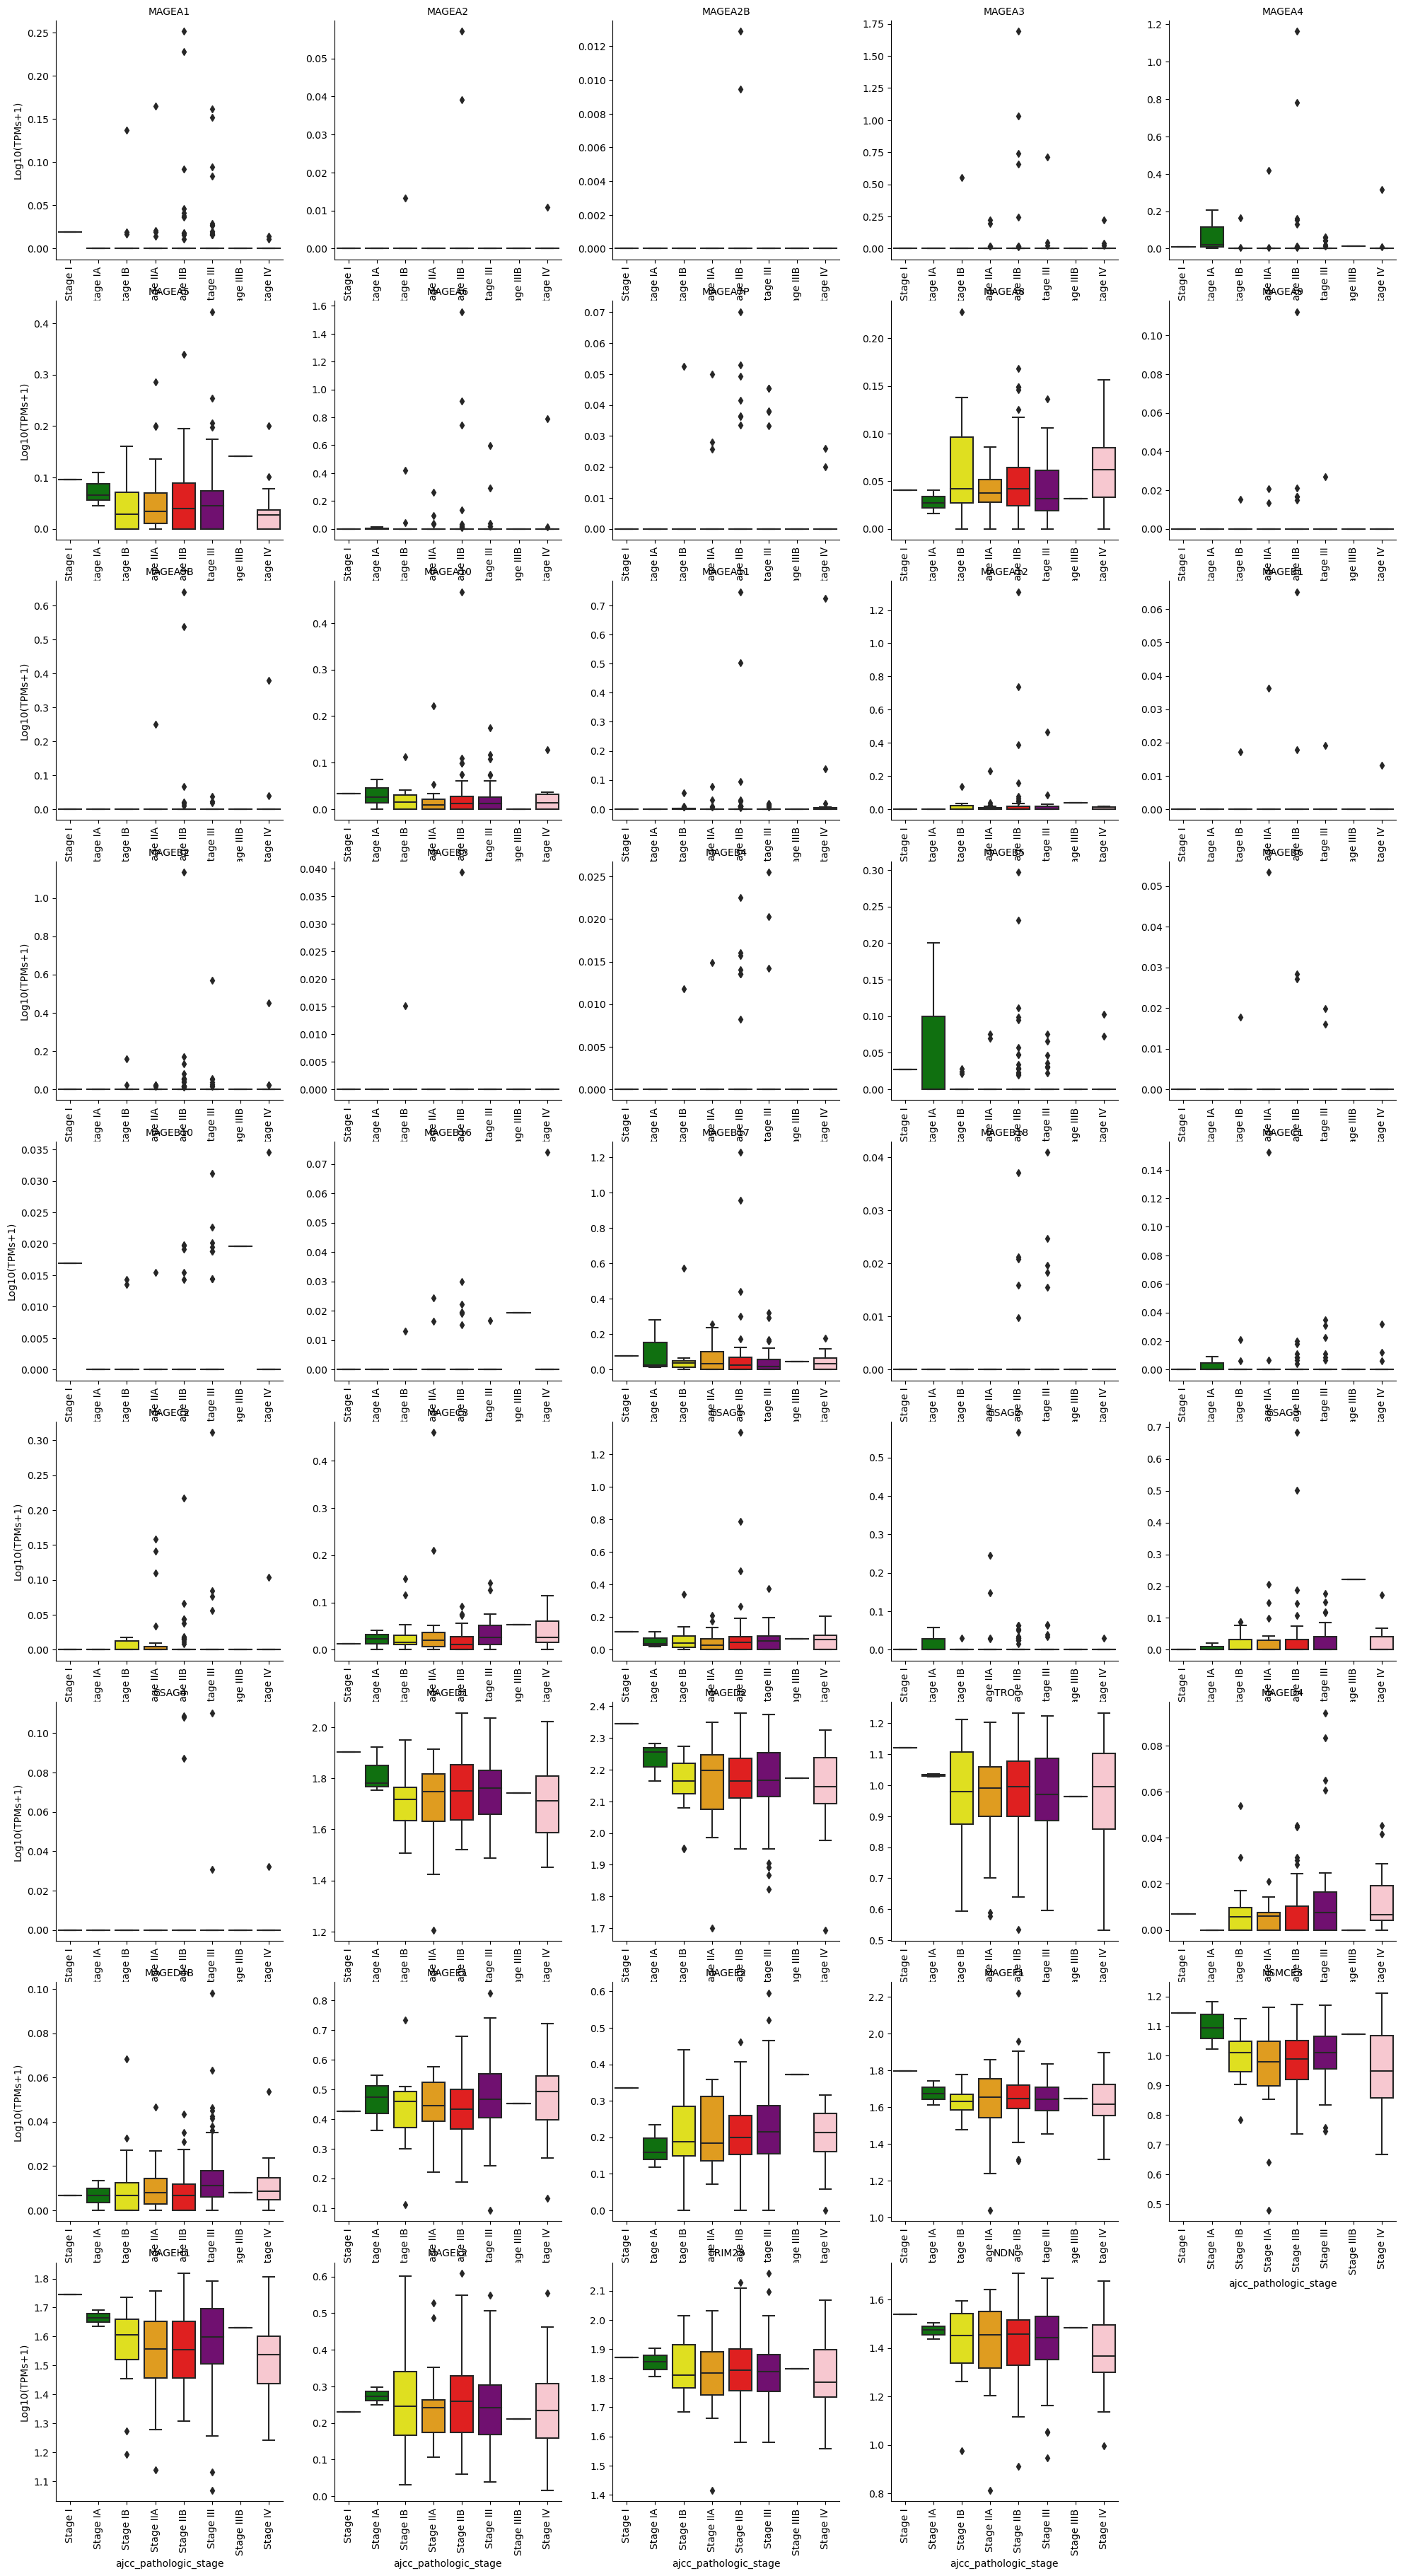

In [43]:
# Ensure the DataFrame contains only the columns in 'column_order' and in the specified order
df_filtered = df[column_order]

# Applying log transformation
df_log_transformed = np.log10(df_filtered + 1)

# Add 'tumor_grade' for grouping in the plot
df_log_transformed['ajcc_pathologic_stage'] = df['ajcc_pathologic_stage']

# Sorting tumor grades by predefined order
stage_order = ["Stage I", "Stage IA", "Stage IB", "Stage IIA", "Stage IIB", "Stage III", "Stage IIIB", "Stage IV"]
df_log_transformed['ajcc_pathologic_stage'] = pd.Categorical(df_log_transformed['ajcc_pathologic_stage'], categories=stage_order, ordered=True)

# Melting the DataFrame to long format for seaborn FacetGrid
df_long = df_log_transformed.melt(id_vars='ajcc_pathologic_stage', var_name='Gene', value_name='Log10(TPMs+1)')
excel_file_path = os.path.join(toData_directory, 'boxplot_data_pathStage.xlsx')
df_long.to_excel(excel_file_path, index=False)

# Define a palette for tumor
palette = {
    "Stage I": "lightblue",
    "Stage IA": "green",
    "Stage IB": "yellow",
    "Stage IIA": "orange",
    "Stage IIB": "red",
    "Stage III": "purple",
    "Stage IIIB": "brown",
    "Stage IV": "pink"
}

# Creating the FacetGrid boxplot with individual y-axes and specific colors
g = sns.FacetGrid(df_long, col='Gene', col_wrap=5, height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.boxplot, x='ajcc_pathologic_stage', y='Log10(TPMs+1)', order=stage_order, palette=palette)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
g.add_legend()
g.savefig(os.path.join(toPlots_directory, 'MAGE_PathStage_boxplot.png'), dpi=300)
plt.show()

In [44]:
data_grade= pd.read_csv('240520_TCGA_CPTAC-3_Output/240520_TCGA_CPTAC-3_Overview/240520_TCGA_CPTAC-3_Data/PathStagePercentage.csv', sep=',',index_col=0)

# Pivot the DataFrame to get the desired format
df_pivot = data_grade.pivot_table(index='gene', columns='classification', values=["Stage I", "Stage IA", "Stage IB", "Stage IIA", "Stage IIB", "Stage III", "Stage IIIB", "Stage IV"])

# Flatten the MultiIndex columns
df_pivot.columns = [f'{grade}{class_type[0]}' for grade, class_type in df_pivot.columns]

# Reset the index to bring the 'gene' column back
df_pivot = df_pivot.reset_index()

# Reorder the DataFrame according to the specified gene order
df_pivot = df_pivot.set_index('gene').reindex(column_order).reset_index()

# Display the result
print(df_pivot)

df_pivot.to_csv(os.path.join(toData_directory, 'transformed_pathStage_percentage.csv'), index=False)


       gene  Stage IN  Stage IP  Stage IAN  Stage IAP  Stage IBN  Stage IBP  \
0    MAGEA1  0.000000  0.564972   1.694915   0.000000   7.344633   1.694915   
1    MAGEA2  0.564972  0.000000   1.694915   0.000000   8.474576   0.564972   
2   MAGEA2B  0.564972  0.000000   1.694915   0.000000   9.039548   0.000000   
3    MAGEA3  0.564972  0.000000   1.694915   0.000000   8.474576   0.564972   
4    MAGEA4  0.000000  0.564972   0.564972   1.129944   7.909605   1.129944   
5    MAGEA5  0.000000  0.564972   0.000000   1.694915   3.389831   5.649718   
6    MAGEA6  0.564972  0.000000   1.129944   0.564972   7.909605   1.129944   
7   MAGEA7P  0.564972  0.000000   1.694915   0.000000   8.474576   0.564972   
8    MAGEA8  0.000000  0.564972   0.000000   1.694915   0.564972   8.474576   
9    MAGEA9  0.564972  0.000000   1.694915   0.000000   8.474576   0.564972   
10  MAGEA9B  0.564972  0.000000   1.694915   0.000000   9.039548   0.000000   
11  MAGEA10  0.000000  0.564972   0.564972   1.12994

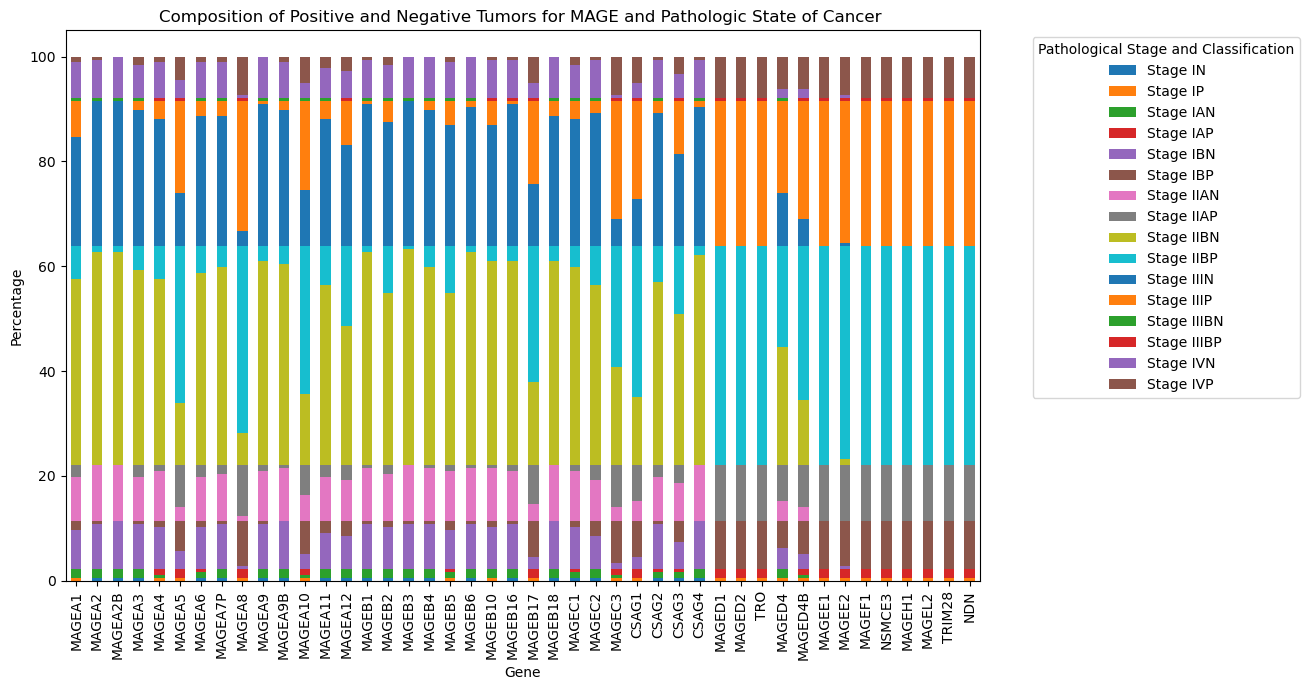

In [45]:
# Plot the stacked bar plot
df_pivot.set_index('gene').plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Composition of Positive and Negative Tumors for MAGE and Pathologic State of Cancer ')
plt.xlabel('Gene')
plt.ylabel('Percentage')
plt.legend(title='Pathological Stage and Classification')
plt.xticks(rotation=90)
plt.tight_layout()
# Place the legend outside the plot
plt.legend(title='Pathological Stage and Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PATHSTAGE_PosNeg_Composition.png'), dpi=300)
plt.show()

<h1><font color="#004D7F" size=5>3. Analysis </font></h1>

<h1><font color="#004D7F" size=4>3.1 Correlation</font></h1>

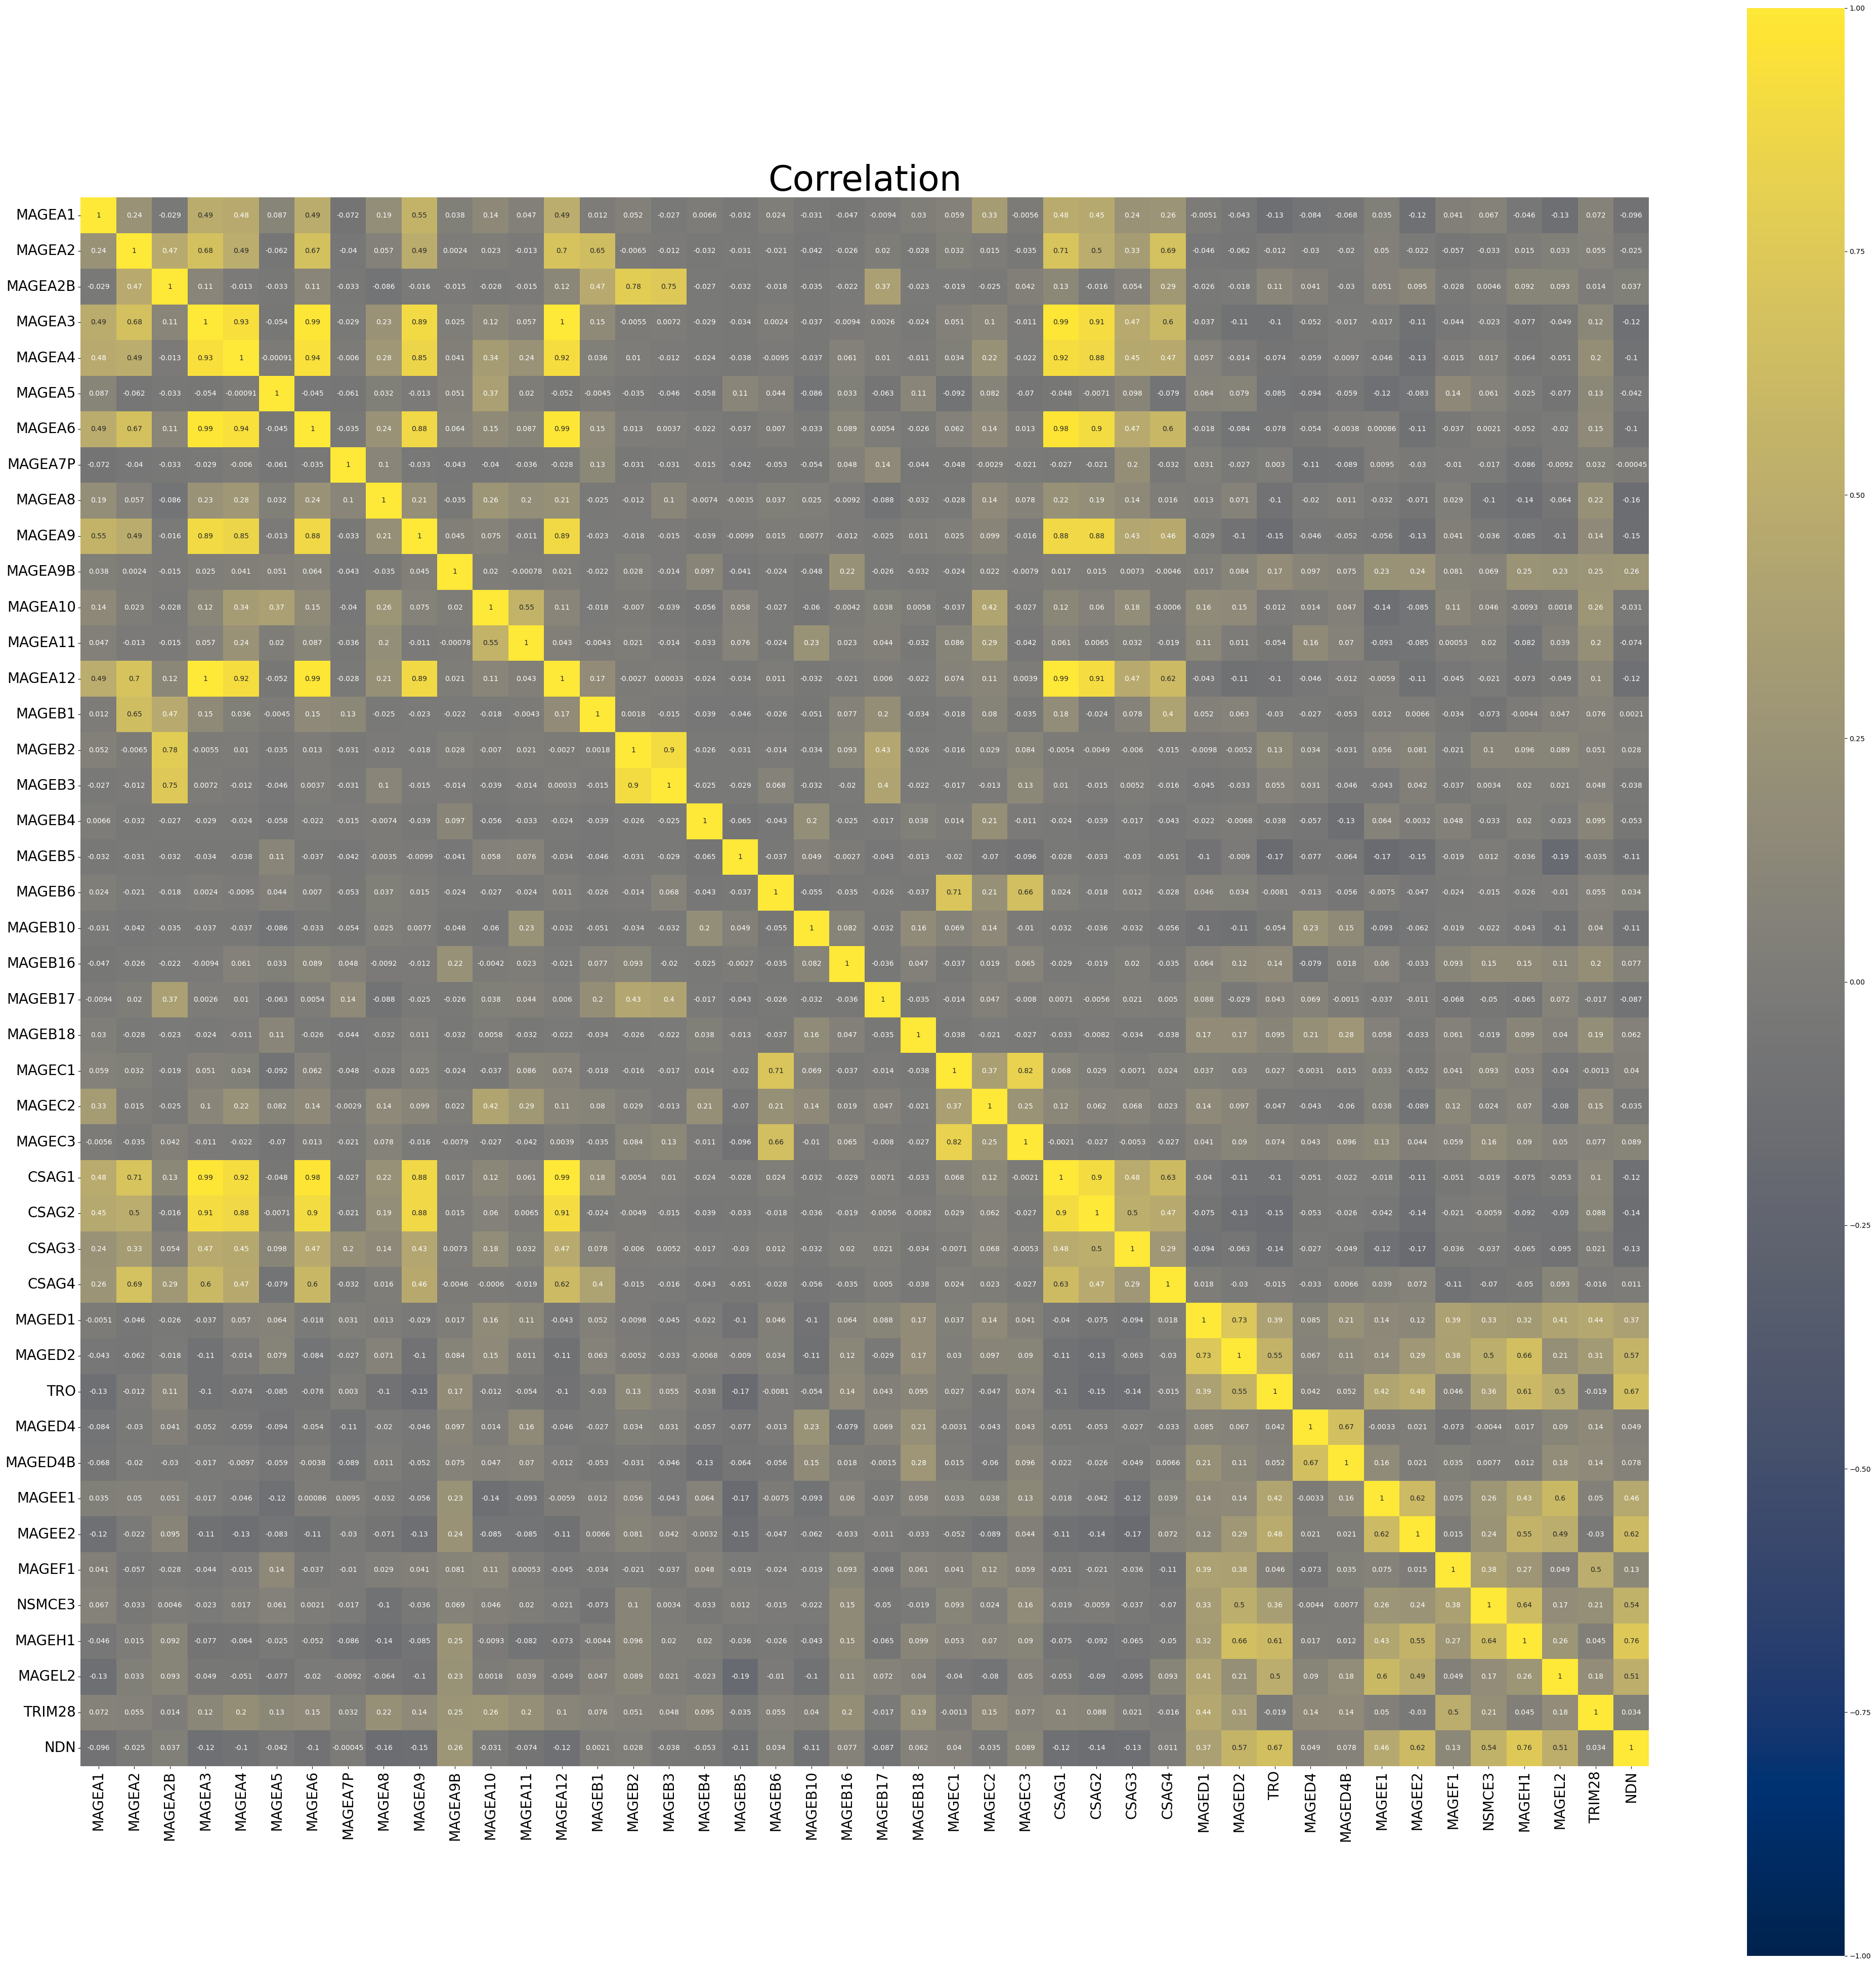

In [17]:
# Perform correlation (Pearson)
correlation = df_numeric.corr()
plt.figure(figsize=(50, 50))
ax = sns.heatmap(correlation, vmax=1, vmin=-1, square=True, annot=True, cmap='cividis')  # Correlations from -1 to 1, change to vmin
correlation.to_csv(os.path.join(toData_directory, 'MAGE_PearsonCorrelation.csv'))
plt.title('Correlation', fontsize=50)  # Increase title font size
plt.xticks(rotation=90)  # Rotate X labels to 90 degrees
plt.yticks(rotation=0)  # Rotate Y labels to default (0 degrees)
# Increase font size of tick labels
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PearsonCorrelation_heatmap.png'), dpi=300)
plt.show()

In [18]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get top absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    '''Get bottom absolute correlations'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    '''Get all absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [19]:
numberCorr=int(input("Enter number of top/bottom correlations to be displayed: "))

Enter number of top/bottom correlations to be displayed: 30


In [20]:
# Print and save top correlations
print('Top of correlations')
topabs = get_top_abs_correlations(df_numeric, numberCorr)
print(topabs)
topabs.to_csv(os.path.join(toData_directory, f'Top_{numberCorr}_Correlation.csv'))

# Print and save bottom correlations
print('\nBottom of correlations')
botabs = get_bottom_abs_correlations(df_numeric, numberCorr)
print(botabs)
botabs.to_csv(os.path.join(toData_directory, f'Bot_{numberCorr}_Correlation.csv'))

Top of correlations
MAGEA3   MAGEA12    0.995670
MAGEA12  CSAG1      0.994689
MAGEA3   CSAG1      0.991418
         MAGEA6     0.988256
MAGEA6   MAGEA12    0.987234
         CSAG1      0.983588
MAGEA4   MAGEA6     0.940109
MAGEA3   MAGEA4     0.930412
MAGEA4   CSAG1      0.920020
         MAGEA12    0.919883
MAGEA3   CSAG2      0.910671
MAGEA12  CSAG2      0.908842
MAGEB2   MAGEB3     0.903880
CSAG1    CSAG2      0.903476
MAGEA6   CSAG2      0.900357
MAGEA3   MAGEA9     0.891325
MAGEA9   MAGEA12    0.890469
         CSAG2      0.881362
MAGEA6   MAGEA9     0.880158
MAGEA9   CSAG1      0.878691
MAGEA4   CSAG2      0.877971
         MAGEA9     0.854609
MAGEC1   MAGEC3     0.820476
MAGEA2B  MAGEB2     0.783106
MAGEH1   NDN        0.755952
MAGEA2B  MAGEB3     0.753885
MAGED1   MAGED2     0.730936
MAGEB6   MAGEC1     0.711688
MAGEA2   CSAG1      0.706698
         MAGEA12    0.699457
dtype: float64

Bottom of correlations
MAGEB5   MAGEL2    -0.191809
         MAGEE1    -0.174050
CSAG3    MAGE

<h1><font color="#004D7F" size=4>3.2 Cutoffs generation</font></h1>

<h1><font color="#004D7F" size=4>3.2.1. Specific Gene</font></h1>

In [21]:
def plot_results(sorted_df, genes, value, optimal_cutoff, sample_names):
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_df[genes[0]])), np.log10(sorted_df[genes[0]] + 1), label='Expression values', color='skyblue')

    # Plot lines at the points where the curve intersects the X-axis for PosNegCriteria and cutoff_value
    posneg_criteria_value = np.log10(value+1)
    plt.axhline(y=posneg_criteria_value, color='g', linestyle='--', label='PosNegCriteria')
    
    intersect_x_posneg = None
    intersect_y_posneg = None
    intersect_x_optimal = None
    intersect_y_optimal = None

    if optimal_cutoff is not None:
        plt.axhline(y=np.log10(optimal_cutoff+1), color='b', linestyle='--', label='Optimal Cutoff')
        # Find the index where the horizontal line intersects with the data for PosNegCriteria
        intersect_index_posneg = np.argmin(np.abs(np.log10(sorted_df[genes[0]]+1) - posneg_criteria_value))
        intersect_x_posneg = intersect_index_posneg
        intersect_y_posneg = np.log10(sorted_df.iloc[intersect_index_posneg][genes[0]] + 1)
        # Find the index where the horizontal line intersects with the data for Optimal Cutoff
        intersect_index_optimal = np.argmin(np.abs(np.log10(sorted_df[genes[0]]+1) - np.log10(optimal_cutoff+1)))
        intersect_x_optimal = intersect_index_optimal
        intersect_y_optimal = np.log10(sorted_df.iloc[intersect_index_optimal][genes[0]] + 1)
        # Plot vertical lines at the intersection points
        plt.axvline(x=intersect_x_optimal, color='m', linestyle='-', label='Optimal Cutoff for high/medium expressed')
    
    if intersect_x_posneg is not None:
        plt.axvline(x=intersect_x_posneg, color='r', linestyle='-', label='Cutoff to Positive Negative')
        
    plt.title(f"Expression classification according with {genes[0]}", fontsize=14)
    plt.xlabel('Samples ID')
    plt.ylabel('Log10(TPM+1)')
    plt.xticks(range(len(sample_names)), sample_names, rotation=90)  # Rotate x-axis labels by 90 degrees
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlotsCutoff_directory, f"Cutoff_Generation_{genes}-gene_barplot.png"), dpi=300)  # Save as PNG with high quality
    plt.show()

def find_optimal_cutoff(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    # Drop rows under positive/negative threshold
    df_subset = df_subset[(df_subset > value).any(axis=1)].dropna()
    # Fit an exponential distribution to the data
    params = expon.fit(df_subset.values.ravel())
    # Generate samples from the fitted distribution
    samples = expon.rvs(*params, size=10000)
    # Cluster the samples using DBSCAN
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    labels = dbscan.fit_predict(samples.reshape(-1, 1))
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Finding optimal cutoff...")
    # Check if there are at least two clusters
    if len(unique_labels) >= 2:
        # Sort clusters by size
        sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        # Calculate the difference between the means of the two largest clusters
        cluster1_indices = np.where(labels == sorted_clusters[0][0])[0]
        cluster2_indices = np.where(labels == sorted_clusters[1][0])[0]
        cluster1_mean = np.mean(samples[cluster1_indices])
        cluster2_mean = np.mean(samples[cluster2_indices])
        diff = np.abs(cluster1_mean - cluster2_mean)
        # Update optimal cutoff and optimal difference if difference is maximized
        optimal_cutoff = np.min([cluster1_mean, cluster2_mean])
        optimal_diff = diff
        optimal_labels = labels
        min_input = np.min(df_subset)
        max_input = np.max(df_subset)
    else:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        optimal_cutoff = None
        optimal_diff = None
        optimal_labels = None
    return optimal_cutoff, optimal_diff, optimal_labels, None

In [29]:
GeneName=input("Enter a Gene-name to be evaluated: ")
PosNegCriteria=float(input("Enter a cut-off value to separate positive and negative tumors: "))

Enter a Gene-name to be evaluated: MAGEA6
Enter a cut-off value to separate positive and negative tumors: 0



Processing MAGEA6
Attempt 1:
Finding optimal cutoff...


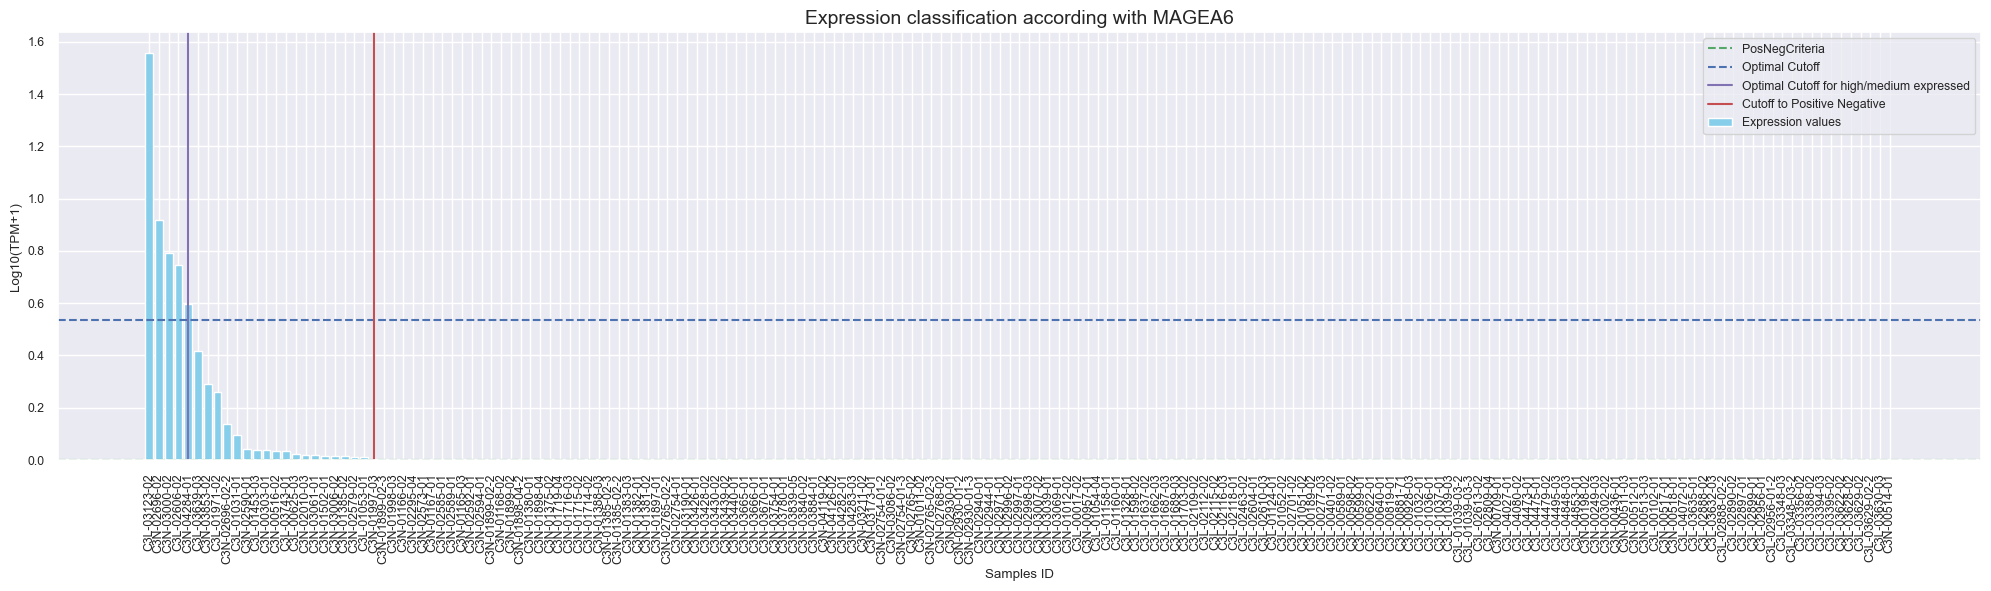

                                            MAGEA6
Parameter                                         
TPM Positive/Negative threshold           0.000000
log10(TPM+1) Positive/Negative threshold  0.000000
Optimal cutoff value                      2.439168
Normalized                                0.536453


In [30]:
# Define the number of attempts
max_attempts = 10
attempt = 1
print(f"\nProcessing {GeneName}")
while attempt <= max_attempts:
    print(f"Attempt {attempt}:")
    cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff(df_numeric, [GeneName], PosNegCriteria)
    
    if cutoff_value is not None and cutoff_value != -1:
        log10_PosNegCriteria = np.log10(PosNegCriteria + 1)
        normalized_cutoff_value = np.log10(cutoff_value + 1)    
        # Sort dataframe based on the selected gene in descending order
        sorted_df = df_numeric.sort_values(by=[GeneName][0], ascending=False)
        sample_names = sorted_df.index  # Extract sample names from index
        plot_results(sorted_df, [GeneName], PosNegCriteria, cutoff_value, sample_names)    
        break  # Exit the loop if a valid cutoff value is found
    else:
        print("Optimal cutoff value not found or equal to -1. Retrying...")
        attempt += 1

# If no valid cutoff value is found within max_attempts, handle accordingly
if attempt > max_attempts:
    print("Maximum attempts reached. Unable to find a valid cutoff value.")
    log10_PosNegCriteria = None
    normalized_cutoff_value = None
    optimal_cutoff = None
    # Sort dataframe based on the selected gene in descending order
    sorted_df = df_numeric.sort_values(by=[GeneName][0], ascending=False)
    sample_names = sorted_df.index  # Extract sample names from index
    plot_results(sorted_df, [GeneName], PosNegCriteria, optimal_cutoff, sample_names)
    
# Create a dictionary with the values
data = {
    "TPM Positive/Negative threshold": [PosNegCriteria],
    "log10(TPM+1) Positive/Negative threshold": [log10_PosNegCriteria],
    "Optimal cutoff value": [cutoff_value],
    "Normalized": [normalized_cutoff_value]
}

# Convert the dictionary into a DataFrame
result_df = pd.DataFrame(data)
# Transpose the DataFrame
result_df = result_df.transpose()
# Rename the column and set the index name
result_df.columns = [GeneName]
result_df.index.name = "Parameter"
result_df.to_csv(os.path.join(toDataCutoff_directory, f'OptimalCutoff_{GeneName}.csv'))
#Print the DataFrame
print(result_df)

<h1><font color="#004D7F" size=4>3.2.2. All set of Genes</font></h1>

In [ ]:
# Initialize a dictionary for basic parameters
basic = {
    "TPM Positive/Negative threshold": None,
    "log10(TPM+1) Positive/Negative threshold": None,
    "Optimal cutoff value": None,
    "Normalized": None
}

# Add an index to the dictionary
index = ["Parameter"]  # Define index values
basic_with_index = {index[0]: list(basic.keys()), **basic}  # Combine index with basic dictionary

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(basic_with_index)

for i, gene in enumerate(column_order):
    attempt = 1
    print(f"\nProcessing {gene}")
    while attempt <= max_attempts:
        print(f"Attempt {attempt}:")
        cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff(df_numeric, [gene], PosNegCriteria)

        if cutoff_value is not None and cutoff_value != -1:
            log10_PosNegCriteria = np.log10(PosNegCriteria + 1)
            normalized_cutoff_value = np.log10(cutoff_value + 1)
            sorted_df = df_numeric.sort_values(by=gene, ascending=False)
            sample_names = sorted_df.index
            plot_results(sorted_df, [gene], PosNegCriteria, cutoff_value, sample_names)
            break
        else:
            print("Optimal cutoff value not found or equal to -1. Retrying...")
            attempt += 1

    if attempt > max_attempts:
        print("Maximum attempts reached. Unable to find a valid cutoff value.")
        log10_PosNegCriteria = None
        normalized_cutoff_value = None
        sorted_df = df_numeric.sort_values(by=gene, ascending=False)
        sample_names = sorted_df.index
        # Assuming optimal_cutoff should be replaced with cutoff_value
        plot_results(sorted_df, [gene], PosNegCriteria, cutoff_value, sample_names)

    data = {
        "TPM Positive/Negative threshold": [PosNegCriteria],
        "log10(TPM+1) Positive/Negative threshold": [log10_PosNegCriteria],
        "Optimal cutoff value": [cutoff_value],
        "Normalized": [normalized_cutoff_value]
    }

    temp_df = pd.DataFrame(data)
    temp_df = temp_df.transpose()
    temp_df.columns = [gene]
    result_df = pd.concat([result_df, temp_df], axis=1)

result_df.to_csv(os.path.join(toDataCutoff_directory, 'OptimalCutoff_general.csv'))

<h1><font color="#004D7F" size=4>3.3. Heatmap</font></h1>

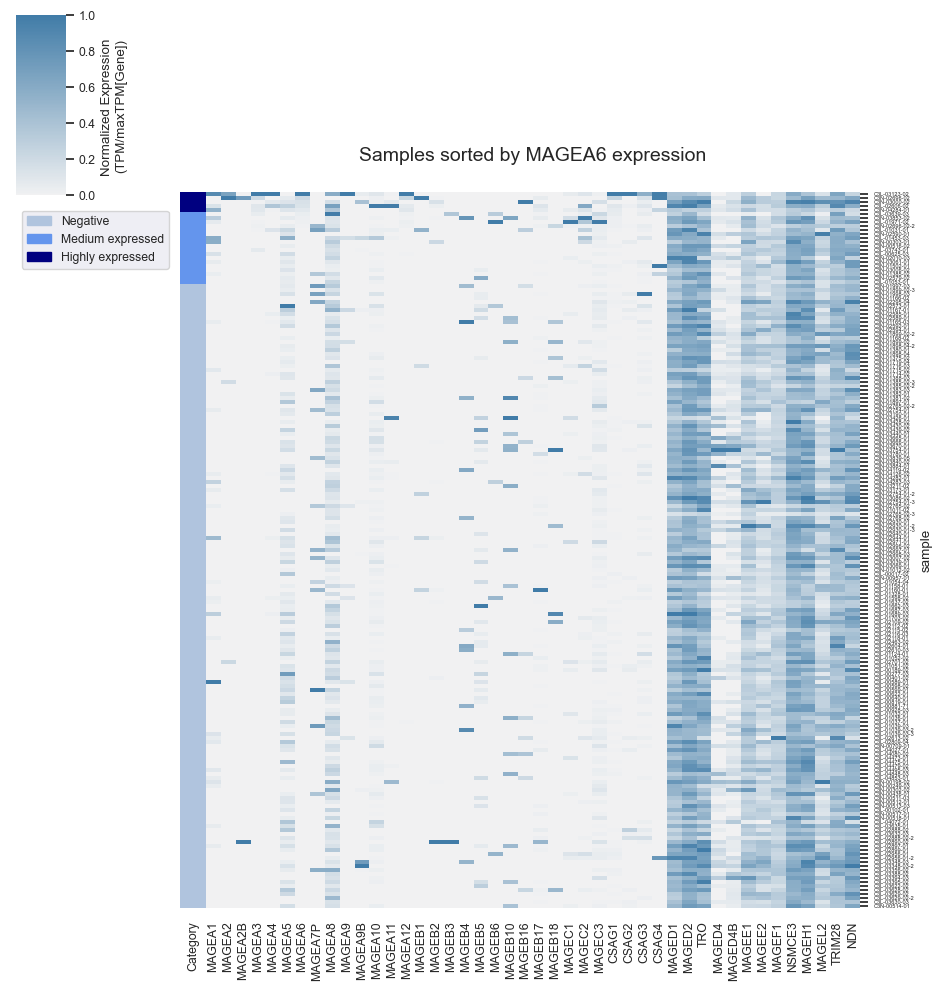

In [31]:
# Define the diverging color palette
custom_cmap = sns.diverging_palette(0, 240, as_cmap=True)
# Sort the DataFrame based on GeneName column
sorted_df_numeric = df_numeric.sort_values(by=GeneName, ascending=False)
# Group rows into categories based on sorted values of GeneName
sorted_df_numeric['Category'] = pd.cut(sorted_df_numeric[GeneName], bins=[-np.inf, PosNegCriteria, cutoff_value, np.inf], labels=['Negative', 'Medium expressed', 'Highly expressed'])
# Map categories to colors
color_map = {'Negative': 'lightsteelblue', 'Medium expressed': 'cornflowerblue', 'Highly expressed': 'navy'}
# Convert category labels to colors
row_colors = sorted_df_numeric['Category'].map(color_map)
# Define function to normalize columns except 'Category'
def normalize_column(col):
    if col.name != 'Category':
        return (col) / (col.max())
    else:
        return col
# Normalize expression values except 'Category'
normalized_df = sorted_df_numeric.apply(normalize_column, axis=0)
normalized_df.to_csv(os.path.join(toData_directory, f'SortedExpression_{GeneName}_Heatmap.csv'))
# Set font scale
sns.set(font_scale=0.8)
# Create the heatmap
g = sns.clustermap(normalized_df.drop('Category', axis=1), center=0, cbar_kws={'label': 'Normalized Expression \n(TPM/maxTPM[Gene])'}, row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True, cmap=custom_cmap, row_colors=row_colors )
# Set font size for y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
# Set tick parameters
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)
# Add text annotation indicating the ordering using GeneName
g.ax_heatmap.text(0.5, 1.05, 'Samples sorted by ' + GeneName + ' expression', horizontalalignment='center', verticalalignment='center', transform=g.ax_heatmap.transAxes, fontsize=14)
# Create a color bar for the category labels
color_bar = sns.color_palette([color_map[x] for x in ['Negative', 'Medium expressed', 'Highly expressed']])
legend = plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in color_bar], labels=color_map.keys(), bbox_to_anchor=(0.000000000001, -0.05), loc='upper left')
# Show the plot
plt.savefig(os.path.join(toPlots_directory, f'SortedExpression_{GeneName}_Heatmap.png'), dpi=300)  # Save as PNG with high quality
plt.show()

<h1><font color="#004D7F" size=4>3.4. Kaplan-Meier curve.</font></h1>

In [38]:
def find_optimal_cutoff_forKM(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    print("Name of gene:", genes)
    #print("Shape of df_subset:", df_subset.shape)
    # Drop rows under positive/negative threshold
    df_subset = df_subset[(df_subset > value).any(axis=1)].dropna()
    # Fit an exponential distribution to the data
    params = expon.fit(df_subset.values.ravel())
    # Generate samples from the fitted distribution
    samples = expon.rvs(*params, size=1000)
    # Cluster the samples using DBSCAN
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    labels = dbscan.fit_predict(samples.reshape(-1, 1))
    unique_labels, counts = np.unique(labels, return_counts=True)
    #print("Finding optimal cutoff...")
    # Check if there are at least two clusters
    if len(unique_labels) >= 2:
        # Sort clusters by size
        sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        # Calculate the difference between the means of the two largest clusters
        cluster1_indices = np.where(labels == sorted_clusters[0][0])[0]
        cluster2_indices = np.where(labels == sorted_clusters[1][0])[0]
        cluster1_mean = np.mean(samples[cluster1_indices])
        cluster2_mean = np.mean(samples[cluster2_indices])
        diff = np.abs(cluster1_mean - cluster2_mean)
        # Update optimal cutoff and optimal difference if difference is maximized
        optimal_cutoff = np.min([cluster1_mean, cluster2_mean])
        optimal_diff = diff
        optimal_labels = labels
        min_input = np.min(df_subset)
        max_input = np.max(df_subset)
    else:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        return value, None, None, None
    # Sort dataframe based on the selected gene in descending order
    sorted_df = df.sort_values(by=genes[0], ascending=False)
    sample_names = sorted_df.index  # Extract sample names from index
    return optimal_cutoff, optimal_diff, optimal_labels, None

# Function to save KM data to CSV
def save_km_data_to_csv(kmf, filename):
    km_data = pd.DataFrame({
        'timeline': kmf.timeline,
        'survival_probability': kmf.survival_function_.values.flatten()
    })
    km_data.to_csv(filename, index=False)

Name of gene: ['MAGEA1']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA2']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA2B']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA3']
Name of gene: ['MAGEA4']
Name of gene: ['MAGEA5']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA6']
Name of gene: ['MAGEA7P']
Name of gene: ['MAGEA8']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA9']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA9B']
Name of gene: ['MAGEA10']
No optimal cutoff found greater than PosNegCriteria. Returning default values.
Name of gene: ['MAGEA11']
Name of gene: ['MAGEA12']
Name of gene: ['MAGEB1']
No optimal cutoff found greater than PosNegCriteria. Returning def

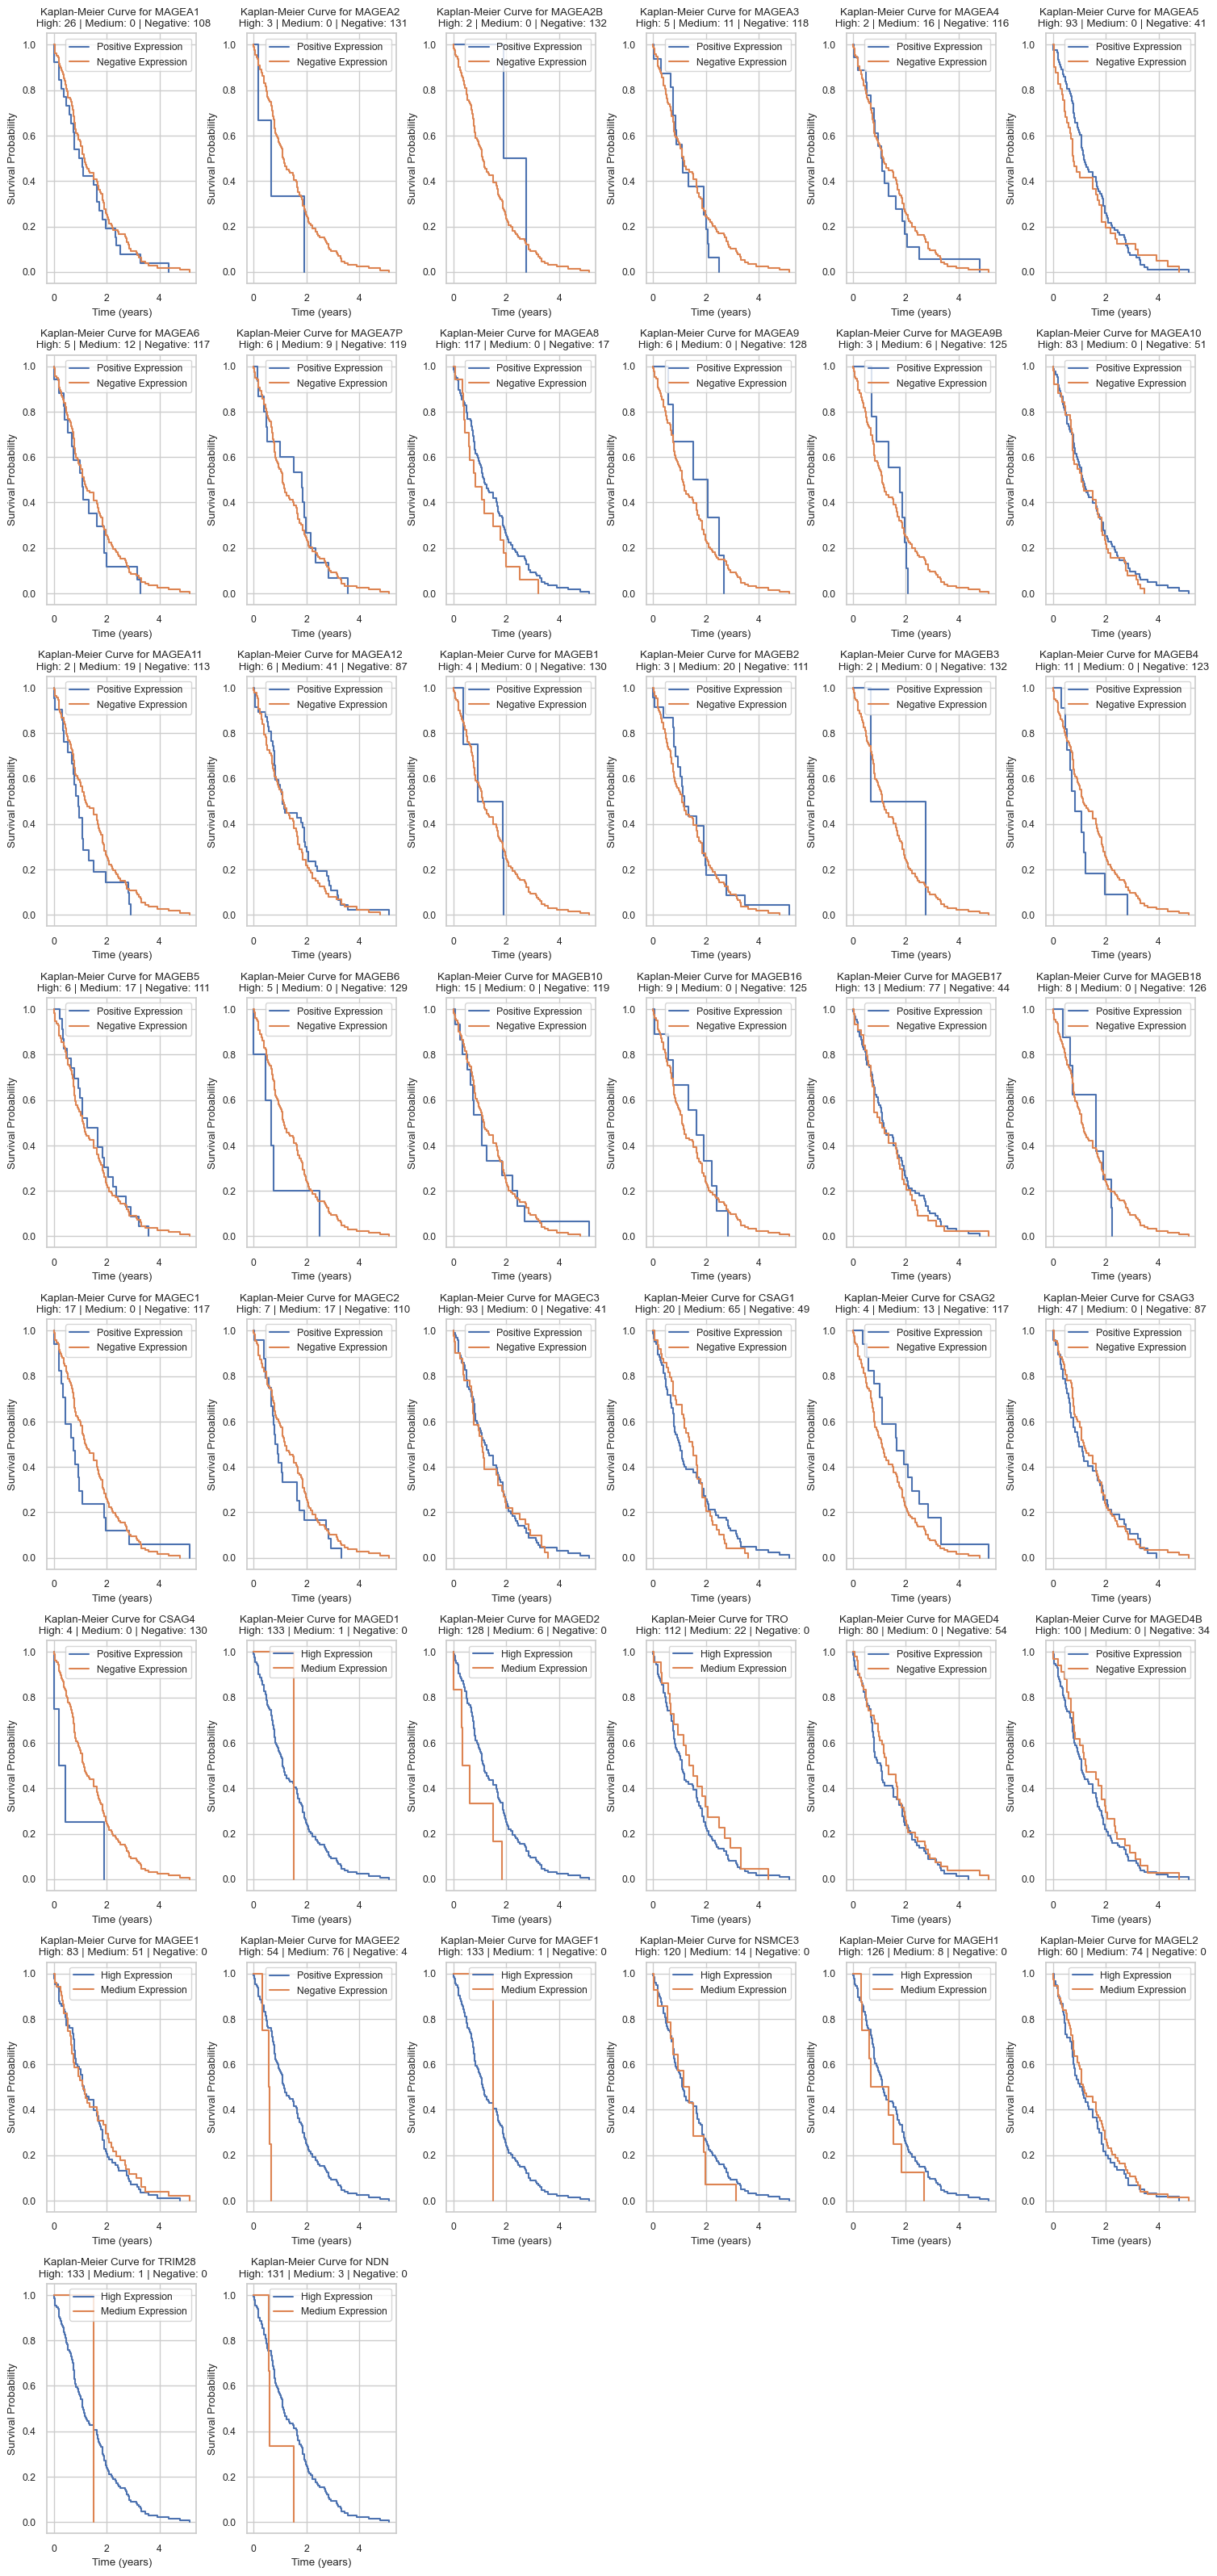

In [39]:
# Drop rows with missing or non-numeric values
df = df.dropna(subset=['days_to_death', 'vital_status'])
df = df[pd.to_numeric(df['days_to_death'], errors='coerce').notnull()]  # Ensure 'days_to_death' contains numeric values
df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')
# Convert 'vital_status' to categorical values
df['vital_status'] = df['vital_status'].astype('category')
# Plotting
num_cols = 6
num_rows = (len(column_order) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 4 * num_rows))  # Adjust figure size based on the number of rows
sns.set_style("whitegrid")

# Iterate over each gene column
for i, gene in enumerate(column_order):
    plt.subplot(num_rows, num_cols, i + 1)
    cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff_forKM(df, [gene], 0)
    # Filter the data based on gene expression levels
    high_expr_data = df[df[gene] > cutoff_value]
    medium_expr_data = df[(df[gene] > 0) & (df[gene] <= cutoff_value)]
    negative_expr_data = df[df[gene] == 0]  # Filter for values equal to 0
    #print(f' {high_expr_data.shape[0]},{medium_expr_data.shape[0]},{negative_expr_data.shape[0]}, {high_expr_data.shape[0]+medium_expr_data.shape[0]+negative_expr_data.shape[0]}' )
    # Check if there are no negative expression data points
    if negative_expr_data.shape[0] == 0:
        # Fit the Kaplan-Meier curve for high expression data
        kmf = KaplanMeierFitter()
        kmf.fit(durations=high_expr_data['days_to_death']/365, event_observed=high_expr_data['vital_status'] == 'Dead', label='High Expression')
        kmf.plot(ci_show=False)
        # Fit the Kaplan-Meier curve for medium expression data if there are entries
        if not medium_expr_data.empty:
            kmf.fit(durations=medium_expr_data['days_to_death']/365, event_observed=medium_expr_data['vital_status'] == 'Dead', label='Medium Expression')
            kmf.plot(ci_show=False)
            save_km_data_to_csv(kmf, f'km_medium_expression_{gene}.csv')
    else:
        positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
        # Create a KaplanMeierFitter object
        kmf = KaplanMeierFitter()
        # Fit the Kaplan-Meier curve for positive expression data
        kmf.fit(durations=positive_expr_data['days_to_death']/365, event_observed=positive_expr_data['vital_status'] == 'Dead', label='Positive Expression')
        kmf.plot(ci_show=False)
        save_km_data_to_csv(kmf, f'km_positive_expression_{gene}.csv')
        if not negative_expr_data.empty:
            kmf.fit(durations=negative_expr_data['days_to_death']/365, event_observed=negative_expr_data['vital_status'] == 'Dead', label='Negative Expression')
            kmf.plot(ci_show=False)
            save_km_data_to_csv(kmf, f'km_negative_expression_{gene}.csv')

    # Add labels and title
    plt.xlabel('Time (years)')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Curve for {gene} \n High: {high_expr_data.shape[0]} | Medium: {medium_expr_data.shape[0]} | Negative: {negative_expr_data.shape[0]}')
    # Add legend
    plt.legend()
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.savefig(os.path.join(toPlots_directory, f'Kaplan-Meier.png'), dpi=300)  # Save as PNG with high quality
plt.show()

<h1><font color="#004D7F" size=5>4. DEA experimental design </font></h1>

In [ ]:
################ CREATING FILES TO DEA  ##############################################
data_raw= pd.read_csv(dataset_raw, sep=',',index_col=0)
raw = pd.DataFrame(data_raw)
transposed_raw= raw.transpose()
columnExample= ["MAGEA1"]
# Iterate over each gene column
for i, gene in enumerate(column_order):
    cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff_forKM(df, [gene], 0)
    # Filter the data based on gene expression levels
    high_expr_data = df[df[gene] > cutoff_value]
    medium_expr_data = df[(df[gene] > 0) & (df[gene] <= cutoff_value)]
    negative_expr_data = df[df[gene] == 0]
    minimumSamples=3 # minimum of samples per category to perform DEA
    if cutoff_value ==0:
        if int(negative_expr_data.shape[0]) >= minimumSamples:
            positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
            print(f'Creating Negative ({negative_expr_data.shape[0]}) vs Positive ({positive_expr_data.shape[0]}) cls file')
            # obtaining samples names
            positiveSamples=positive_expr_data.index
            negativeSamples=negative_expr_data.index
            #Creating dataframes
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            positivesdf= pd.DataFrame(positiveSamples)
            positivesdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([negativesdf, positivesdf], ignore_index=True)
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsPOS_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsPOS_RAW.csv")
            TotalIndex = combined_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename} \n')
        else:
            print(f'Please modify positive/negative cutoff to have at least 3 samples per category. Current: {negative_expr_data.shape[0]} negative samples and {positive_expr_data.shape[0]} positive samples\n')
    else:  
        if medium_expr_data.shape[0] >=minimumSamples and high_expr_data.shape[0] >=minimumSamples and negative_expr_data.shape[0] >=minimumSamples: #all categories accomplished
            print(f'Creating Medium ({medium_expr_data.shape[0]})  vs High ({high_expr_data.shape[0]}), Negative ({negative_expr_data.shape[0]}) vs High ({high_expr_data.shape[0]}), and Negative ({negative_expr_data.shape[0]}) vs Medium ({medium_expr_data.shape[0]})cls files')
             # obtaining samples names
            highSamples=high_expr_data.index
            mediumSamples = medium_expr_data.index
            negativeSamples=negative_expr_data.index
            #merging and writing to csv
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            combined_df = pd.concat([mediumdf, highdf], ignore_index=True)
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_MEDvsHIG_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_MEDvsHIG_RAW.csv")
            TotalIndex = combined_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)        
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}')
            
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            combined2_df = pd.concat([negativesdf, highdf], ignore_index=True)
            print(f'{combined2_df}')
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsHIG_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsHIG_RAW.csv")
            TotalIndex = combined2_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)
            combined2_df.to_csv(filename, index=False)

            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Treatment'
            combined3_df = pd.concat([negativesdf, mediumdf], ignore_index=True)
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsMED_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsMED_RAW.csv")
            TotalIndex = combined3_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)
            combined3_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')
            
        elif medium_expr_data.shape[0] <minimumSamples or high_expr_data.shape[0] <minimumSamples and negative_expr_data.shape[0] >=minimumSamples: #medium or high are insufficient
            positive_expr_data = pd.concat([high_expr_data, medium_expr_data])
            print(f'Creating Negative ({negative_expr_data.shape[0]}) vs Positive ({positive_expr_data.shape[0]}) cls file due to small (<3) sample size for High ({high_expr_data.shape[0]}) or Medium ({medium_expr_data.shape[0]}) categories')        
            # obtaining samples names
            positiveSamples=positive_expr_data.index
            negativeSamples=negative_expr_data.index
            #Creating dataframes
            negativesdf=pd.DataFrame(negativeSamples)
            negativesdf['condition']= 'Control'
            positivesdf= pd.DataFrame(positiveSamples)
            positivesdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([negativesdf, positivesdf], ignore_index=True)
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsPOS_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_NEGvsPOS_RAW.csv")
            TotalIndex = combined_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')
        elif negative_expr_data.shape[0] <minimumSamples and (medium_expr_data.shape[0] <minimumSamples or high_expr_data.shape[0] <minimumSamples): #Only medium or only High
            print(f'Please modify positive/negative cutoff to have at least 3 samples per category. Current: {negative_expr_data.shape[0]} negative, {medium_expr_data.shape[0]} medium ,and {high_expr_data.shape[0]} high samples\n')
        else: #Case for typical Type 2 gene (Negative <3 and samples are into High and medium)
            print(f'Creating High ({high_expr_data.shape[0]}) vs Medium ({medium_expr_data.shape[0]}) cls file due to small (<3) sample size for Negative category ({negative_expr_data.shape[0]})')
            # obtaining samples names
            highSamples=high_expr_data.index
            mediumSamples = medium_expr_data.index
            #Creating dataframes
            mediumdf=pd.DataFrame(mediumSamples)
            mediumdf['condition']= 'Control'
            highdf= pd.DataFrame(highSamples)
            highdf['condition']= 'Treatment'
            #merging and writing to csv
            combined_df = pd.concat([mediumdf, highdf], ignore_index=True)
            filename=os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_MEDvsHIG_DES.csv")
            filename_raw= os.path.join(deainput_directory, f"{formatted_date}_TCGA_{projectName}_{gene}_MEDvsHIG_RAW.csv")
            TotalIndex = combined_df['sample']
            transposed_sorted = transposed_raw[TotalIndex]
            transposed_sorted.to_csv(filename_raw, index=True)
            combined_df.to_csv(filename, index=False)
            print(f'Combined data has been written to: {filename}\n')

In [ ]:
# Check if the directory exists
if not os.path.exists(deainput_directory):
    print(f"Error: The directory '{deainput_directory}' does not exist.")
else:
    # Get a sorted list of files
    files = sorted(os.listdir(deainput_directory))

    # Check if you have permission to write in the current directory
    try:
        with open(os.path.join(deainput_directory, 'directory_mapping.csv'), 'w') as file:
            # Initial flag for pairing files
            flag = True
            # Loop through the sorted files
            for f in files:
                if flag:
                    # Capture the first file of the pair
                    m1 = f
                    flag = False
                    # Extract the output name from the first file name, before an underscore
                    out = f.split('_DES')[0]
                else:
                    # Write the constructed string for the pair to the file
                    file.write(f"{deainput_directory}/{m1},{deainput_directory}/{f},{deaoutput_directory}/{out}\n")
                    # Reset the flag to capture the next pair
                    flag = True
        print(f"File 'directory_mapping.csv' created successfully in {deaoutput_directory}")
    except PermissionError:
        print(f"Permission denied: Unable to write to the directory {deaoutput_directory}")

<h1><font color="#004D7F" size=5>5. Normal-tissue subset analysis </font></h1>

<h1><font color="#004D7F" size=4>5.1. Creating directory data structure </font></h1>

In [ ]:
# Get the current working directory
working_directory = os.getcwd()
print(working_directory)
# Get the current date
current_date = datetime.now()
# Format the date as YYMMDD
formatted_date = current_date.strftime('%y%m%d')
# Define directory paths
output_directory = os.path.join(working_directory, f"{formatted_date}_TCGA_{projectName}-normal_Output")
overview_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}-normal_Overview")
toPlots_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}-normal_Plots")
#toPlotsCutoff_directory = os.path.join(toPlots_directory, f"{formatted_date}_TCGA_{projectName}-normal_Cutoff")
toData_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}-normal_Data")
#toDataCutoff_directory = os.path.join(toData_directory, f"{formatted_date}_TCGA_{projectName}-normal_Cutoff")
todea_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}-normal_DEA")
deainput_directory = os.path.join(todea_directory, f"{formatted_date}_TCGA_{projectName}-normal_DEA_Input")
# Create directories if they don't exist
os.makedirs(output_directory, exist_ok=True)
os.makedirs(overview_directory, exist_ok=True)
os.makedirs(toPlots_directory, exist_ok=True)
#os.makedirs(toPlotsCutoff_directory, exist_ok=True)
os.makedirs(toData_directory, exist_ok=True)
#os.makedirs(toDataCutoff_directory, exist_ok=True)
os.makedirs(todea_directory, exist_ok=True)
os.makedirs(deainput_directory, exist_ok=True)
print("Directories created successfully:")
print(output_directory)
print(overview_directory)
print(toPlots_directory)
print(toPlotsCutoff_directory)
print(toData_directory)
print(toDataCutoff_directory)
print(todea_directory)
print(deainput_directory)

<h1><font color="#004D7F" size=4>5.2. Loading input table </font></h1>

In [ ]:
datasetnormal=input("Enter path for csv file: ") 
#C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv GBM
#C:/Users/TTUSVM/Documents/TCGA2/Output/240425_TCGA-PAAD/240425_TCGA-PAAD_tpm_clinical.csv   PAAD
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv CPTAC-3
#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3-normal\240502_CPTAC-3-normal_tpm_clinical.csv  CPTAC-3 normal

In [ ]:
# replace empty/invalid values with NaN
datanormal= pd.read_csv(datasetnormal, sep=',')
dfnormal = pd.DataFrame(datanormal)
dfnormal.replace("\'--", np.nan, inplace=True)
dfnormal.replace('not reported', np.nan, inplace=True)
dfnormal.replace('Not Reported', np.nan, inplace=True)
dfnormal.set_index('sample', inplace=True)
dfnormal

In [ ]:
# Count of null data points
print(dfnormal.isnull().sum())

In [ ]:
# drop columns with >0.5 NaN's
dfnormal = dfnormal.loc[:, dfnormal.isnull().mean() < .5]
dfnormal.info()

In [ ]:
dfnormal.describe()
# Write DataFrame description to CSV
dfnormal.describe().to_csv(os.path.join(toData_directory, 'DescriptiveStatistics.csv'))

<h1><font color="#004D7F" size=5>6. Visualization</font></h1>

In [ ]:
dfnormal_numeric = dfnormal.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"
]
#df_numeric = df_numeric[column_order]
dfnormal_numeric=dfnormal_numeric[column_order]

In [ ]:
df_numeric

<h1><font color="#004D7F" size=4>6.1 Distribution of TPMs expression.</font></h1>

In [ ]:
# Set colors
colors_pastel = sns.color_palette("Set2")

def plot_gene_histograms_type1(gene_list):
    num_genes = len(gene_list)
    num_rows = (num_genes // 6) + (1 if num_genes % 6 != 0 else 0)  # Calculate number of rows
    plt.figure(figsize=(15, 2 * num_rows))
    for i, gene in enumerate(gene_list, start=1):
        plt.subplot(num_rows, 6, i)
        plt.hist(np.log10(dfnormal_numeric[gene] + 1), bins=20, color=colors_pastel[2], edgecolor='black')
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type1_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()
    
def plot_gene_histograms_type2(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(dfnormal_numeric[gene] + 1), bins=20, color=colors_pastel[5], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type2_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()

In [ ]:
Type1 = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3","CSAG1", "CSAG2", "CSAG3", "CSAG4"]
Type2 = [ "MAGED1", "MAGED2", "TRO","MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"]
plot_gene_histograms_type1(Type1)
plot_gene_histograms_type2(Type2)

<h1><font color="#004D7F" size=5>7. Analysis </font></h1>

<h1><font color="#004D7F" size=4>7.1 Correlation</font></h1>

In [ ]:
# Perform correlation (Pearson)
correlationnormal = dfnormal_numeric.corr()
plt.figure(figsize=(50, 50))
ax = sns.heatmap(correlationnormal, vmax=1, vmin=-1, square=True, annot=True, cmap='cividis')  # Correlations from -1 to 1, change to vmin
correlationnormal.to_csv(os.path.join(toData_directory, 'MAGE_PearsonCorrelation.csv'))
plt.title('Correlation', fontsize=50)  # Increase title font size
plt.xticks(rotation=90)  # Rotate X labels to 90 degrees
plt.yticks(rotation=0)  # Rotate Y labels to default (0 degrees)
# Increase font size of tick labels
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PearsonCorrelation_heatmap.png'), dpi=300)
plt.show()

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get top absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    '''Get bottom absolute correlations'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    '''Get all absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [ ]:
numberCorrnormal=int(input("Enter number of top/bottom correlations to be displayed: "))

In [ ]:
# Print and save top correlations
print('Top of correlations')
topabsnormal = get_top_abs_correlations(dfnormal_numeric, numberCorrnormal)
print(topabsnormal)
topabsnormal.to_csv(os.path.join(toData_directory, f'Top_{numberCorrnormal}_Correlation.csv'))

# Print and save bottom correlations
print('\nBottom of correlations')
botabsnormal = get_bottom_abs_correlations(dfnormal_numeric, numberCorrnormal)
print(botabsnormal)
botabsnormal.to_csv(os.path.join(toData_directory, f'Bot_{numberCorrnormal}_Correlation.csv'))

In [ ]:
df_numeric['source'] = 'df_numeric'
dfnormal_numeric['source'] = 'dfnormal_numeric'
df_combined = pd.concat([df_numeric, dfnormal_numeric], axis=0, ignore_index=False)
#df_combined = df_combined.iloc[:, :-1]
df_combined.to_csv(os.path.join(toData_directory, 'CombinedNormalvsTumors.csv'))
df_combined
df_numeric_normal_combined = df_combined.iloc[:, :-1]

<h1><font color="#004D7F" size=4>7.2. Heatmap</font></h1>

In [ ]:
# Define the diverging color palette
custom_cmap = sns.diverging_palette(0, 240, as_cmap=True)
# Define function to normalize columns except 'Category'
def normalize_column(col):
    if col.name != 'source':
        return (col) / (col.max())
    else:
        return col

# Normalize expression values except 'Category'
normalized_combined_df = df_combined.apply(normalize_column, axis=0)
#normalized_df.to_csv(os.path.join(toData_directory, f'SortedExpression_{GeneName}_Heatmap.csv'))
# Set font scale
sns.set(font_scale=0.8)
# Create the heatmap
g = sns.clustermap(normalized_combined_df.drop('source', axis=1), center=0, cbar_kws={'label': 'Normalized Expression \n(TPM/maxTPM[Gene])'}, row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True, cmap=custom_cmap )
# Set font size for y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
# Set tick parameters
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)
# Add text annotation indicating the ordering using GeneName
#g.ax_heatmap.text(0.5, 1.05, 'Samples sorted by ' + GeneName + ' expression', horizontalalignment='center', verticalalignment='center', transform=g.ax_heatmap.transAxes, fontsize=14)
# Create a color bar for the category labels
#color_bar = sns.color_palette([color_map[x] for x in ['Negative', 'Medium expressed', 'Highly expressed']])
#legend = plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in color_bar], labels=color_map.keys(), bbox_to_anchor=(0.000000000001, -0.05), loc='upper left')
# Show the plot
#plt.savefig(os.path.join(toPlots_directory, f'SortedExpression_{GeneName}_Heatmap.png'), dpi=300)  # Save as PNG with high quality
plt.show()

<h1><font color="#004D7F" size=5>8. Machine learning training </font></h1>

<h1><font color="#004D7F" size=4>8.1. Support Vector Machine </font></h1>

In [ ]:
# Assuming the 'source' column is your label
X = df_combined.drop('source', axis=1)  # Features
y = df_combined['source']  # Labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Example values
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Example values
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

In [ ]:
# Re-train with the best parameters
final_model = SVC(C=10, gamma='scale', kernel='rbf')
final_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_final = final_model.predict(X_test_scaled)

# Evaluate the model
print("Final Accuracy on Test Set:", accuracy_score(y_test, y_pred_final))
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<h1><font color="#004D7F" size=4>8.2. Random Forest </font></h1>

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)
# Predict the test set results
y_pred = rf_classifier.predict(X_test_scaled)
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Summarize feature importances
feature_names = X.columns
feature_imports = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_imports.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
tree = rf_classifier.estimators_[0]
# Set the size of the plot
plt.figure(figsize=(20,10))

# Plot the tree
plot_tree(tree, 
          filled=True, 
          rounded=True, 
          class_names=['df_numeric', 'dfnormal_numeric'],  # Update class names as appropriate
          feature_names=X.columns,
          max_depth=3)  # You can change or remove the max_depth to show more or all levels of the tree

# Show the plot
plt.show()

<h1><font color="#004D7F" size=5> 9. SIMA Genes analysis  </font></h1>

<h1><font color="#004D7F" size=4>9.1.Creating directory data structure </font></h1>

In [ ]:
# Get the current working directory
working_directory = os.getcwd()
print(working_directory)
# Get the current date
current_date = datetime.now()
# Format the date as YYMMDD
formatted_date = current_date.strftime('%y%m%d')
# Define directory paths
output_directory = os.path.join(working_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_Output")
overview_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_Overview")
toPlots_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_Plots")
#toPlotsCutoff_directory = os.path.join(toPlots_directory, f"{formatted_date}_TCGA_{projectName}-normal_Cutoff")
toData_directory = os.path.join(overview_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_Data")
#toDataCutoff_directory = os.path.join(toData_directory, f"{formatted_date}_TCGA_{projectName}-normal_Cutoff")
todea_directory = os.path.join(output_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_DEA")
deainput_directory = os.path.join(todea_directory, f"{formatted_date}_TCGA_{projectName}-SIMA_DEA_Input")
# Create directories if they don't exist
os.makedirs(output_directory, exist_ok=True)
os.makedirs(overview_directory, exist_ok=True)
os.makedirs(toPlots_directory, exist_ok=True)
#os.makedirs(toPlotsCutoff_directory, exist_ok=True)
os.makedirs(toData_directory, exist_ok=True)
#os.makedirs(toDataCutoff_directory, exist_ok=True)
os.makedirs(todea_directory, exist_ok=True)
os.makedirs(deainput_directory, exist_ok=True)
print("Directories created successfully:")
print(output_directory)
print(overview_directory)
print(toPlots_directory)
print(toPlotsCutoff_directory)
print(toData_directory)
print(toDataCutoff_directory)
print(todea_directory)
print(deainput_directory)

<h1><font color="#004D7F" size=4>9.2. Loading input table </font></h1>

In [ ]:
datasetsima=input("Enter path for csv file: ") 
#C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv GBM
#C:/Users/TTUSVM/Documents/TCGA2/Output/240425_TCGA-PAAD/240425_TCGA-PAAD_tpm_clinical.csv   PAAD
#C:\Users\TTUSVM\Documents\TCGA2\Output\240425_CPTAC-3\240425_CPTAC-3_tpm_clinical.csv CPTAC-3
#C:\Users\TTUSVM\Documents\TCGA2\Output\240502_CPTAC-3-normal\240502_CPTAC-3-normal_tpm_clinical.csv  CPTAC-3 normal


#C:\Users\TTUSVM\Documents\TCGA2\Output\240503_CPTAC-3-sima\240503_CPTAC-3_tpm_clinical.csv 

In [ ]:
# replace empty/invalid values with NaN
datasima= pd.read_csv(datasetsima, sep=',')
dfsima = pd.DataFrame(datasima)
dfsima.replace("\'--", np.nan, inplace=True)
dfsima.replace('not reported', np.nan, inplace=True)
dfsima.replace('Not Reported', np.nan, inplace=True)
dfsima.set_index('sample', inplace=True)
dfsima

In [ ]:
# Count of null data points
print(dfsima.isnull().sum())

In [ ]:
# drop columns with >0.5 NaN's
dfsima = dfsima.loc[:, dfsima.isnull().mean() < .5]
dfsima.info()

In [ ]:
dfsima.describe()
# Write DataFrame description to CSV
dfsima.describe().to_csv(os.path.join(toData_directory, 'DescriptiveStatistics.csv'))

<h1><font color="#004D7F" size=5>10. Visualization</font></h1>

In [ ]:
dfsima_numeric = dfsima.select_dtypes(include=['number'])
# Reorder columns based on the provided order
columnsima_order = [
    'IFI16', 'SFN', 'MAP2', 'PDLIM1', 'FGF2', 'PTX3', 'GRAMD2B', 'TMEM40', 'CASP1', 'COL3A1',
    'ADAMTSL1', 'PCDH1', 'PLCXD3', 'TLR8', 'CARD16', 'TNFSF18', 'STAMBPL1', 'KRT16', 'UBASH3B', 'ACTA2',
    'MID1IP1', 'ALDH7A1', 'AIM2', 'PELI2', 'EMC10', 'CD14', 'A4GALT', 'CAMK1G', 'CARD17', 'FAS',
    'LRP1B', 'IL18', 'GPR87', 'ADAM23', 'GLI3', 'PPP3CA', 'GJC2', 'SAMSN1', 'CXCL1', 'SDC1',
    'EMCN', 'TRIML2', 'PCDH7', 'RAPGEF5', 'NRG2', 'PEG10', 'KCNE1B', 'TNS1', 'LAMA4', 'SEC14L4',
    'CORO2B', 'ENPP1', 'PRKAA2', 'HKDC1', 'ANKRD22', 'IGFBP1', 'WNT3', 'FZD8', 'GRIA2', 'ITGA3',
    'CDH12', 'ITGA10', 'PKP2', 'CDKN1A', 'MGP', 'SUCNR1', 'LAMB3', 'COL9A2', 'DDIT4L', 'SCN7A',
    'COL1A2', 'PLD1', 'PIK3R3', 'CA2', 'CERKL', 'NDST3', 'COL6A3', 'CREB3L4', 'AP1S3', 'COL5A1',
    'ATP2A3', 'SLC40A1', 'PDGFRL', 'SHH', 'WNT4', 'GJA1', 'COL17A1', 'UBE2U', 'CGN', 'FRAS1',
    'CASP5', 'CREB3L1', 'TGFB2', 'TP53AIP1', 'TMPRSS13', 'FLNC', 'PLA2G4A', 'FZD1', 'CYP4A22', 'TRO',
    'SP8', 'MYRFL', 'TAC3', 'CYBB', 'THSD7B', 'SPATA4', 'COL18A1', 'KCNK13', 'DTX4', 'PIWIL4',
    'HRNR', 'WNT5A', 'PRR29', 'ATP1B1P1', 'LUM', 'GNG2', 'WNT7B', 'WNT6', 'WNT8A'
]
#df_numeric = df_numeric[column_order]
dfsima_numeric=dfsima_numeric[columnsima_order]

In [ ]:
dfsima_numeric

<h1><font color="#004D7F" size=4>10.1 Distribution of TPMs expression.</font></h1>

In [ ]:
# Set colors
colors_pastel = sns.color_palette("Set2")

def plot_gene_histograms_type1(gene_list):
    num_genes = len(gene_list)
    num_rows = (num_genes // 6) + (1 if num_genes % 6 != 0 else 0)  # Calculate number of rows
    plt.figure(figsize=(15, 2 * num_rows))
    for i, gene in enumerate(gene_list, start=1):
        plt.subplot(num_rows, 6, i)
        plt.hist(np.log10(dfsima_numeric[gene] + 1), bins=20, color=colors_pastel[2], edgecolor='black')
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type1_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()
    
def plot_gene_histograms_type2(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(dfsima_numeric[gene] + 1), bins=20, color=colors_pastel[5], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(toPlots_directory, 'type2_TPM_Expression_histogram.png'), dpi=300)  # Save as PNG with high quality
    plt.show()

In [ ]:
Type1 = ['IFI16', 'SFN', 'MAP2', 'PDLIM1', 'FGF2', 'PTX3', 'GRAMD2B', 'TMEM40', 'CASP1', 'COL3A1',
    'ADAMTSL1', 'PCDH1', 'PLCXD3', 'TLR8', 'CARD16', 'TNFSF18', 'STAMBPL1', 'KRT16', 'UBASH3B', 'ACTA2',
    'MID1IP1', 'ALDH7A1', 'AIM2', 'PELI2', 'EMC10', 'CD14', 'A4GALT', 'CAMK1G', 'CARD17', 'FAS',
    'LRP1B', 'IL18', 'GPR87', 'ADAM23', 'GLI3', 'PPP3CA', 'GJC2', 'SAMSN1', 'CXCL1', 'SDC1',
    'EMCN', 'TRIML2', 'PCDH7', 'RAPGEF5', 'NRG2', 'PEG10', 'KCNE1B', 'TNS1', 'LAMA4', 'SEC14L4',
    'CORO2B', 'ENPP1', 'PRKAA2', 'HKDC1', 'ANKRD22', 'IGFBP1', 'WNT3', 'FZD8', 'GRIA2', 'ITGA3',
    'CDH12', 'ITGA10', 'PKP2', 'CDKN1A', 'MGP', 'SUCNR1', 'LAMB3', 'COL9A2', 'DDIT4L', 'SCN7A',
    'COL1A2', 'PLD1', 'PIK3R3', 'CA2', 'CERKL', 'NDST3', 'COL6A3', 'CREB3L4', 'AP1S3', 'COL5A1',
    'ATP2A3', 'SLC40A1', 'PDGFRL', 'SHH', 'WNT4', 'GJA1', 'COL17A1', 'UBE2U', 'CGN', 'FRAS1',
    'CASP5', 'CREB3L1', 'TGFB2', 'TP53AIP1', 'TMPRSS13', 'FLNC', 'PLA2G4A', 'FZD1', 'CYP4A22', 'TRO',
    'SP8', 'MYRFL', 'TAC3', 'CYBB', 'THSD7B', 'SPATA4', 'COL18A1', 'KCNK13', 'DTX4', 'PIWIL4',
    'HRNR', 'WNT5A', 'PRR29', 'ATP1B1P1', 'LUM', 'GNG2', 'WNT7B', 'WNT6', 'WNT8A']
#Type2 = [ "MAGED1", "MAGED2", "TRO","MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "TRIM28", "NDN"]
plot_gene_histograms_type1(Type1)
#plot_gene_histograms_type2(Type2)

<h1><font color="#004D7F" size=5>11. Analysis </font></h1>

<h1><font color="#004D7F" size=4>11.1 Correlation</font></h1>

In [ ]:
# Perform correlation (Pearson)
correlationsima = dfsima_numeric.corr()
plt.figure(figsize=(50, 50))
ax = sns.heatmap(correlationsima, vmax=1, vmin=-1, square=True, annot=True, cmap='cividis')  # Correlations from -1 to 1, change to vmin
correlationsima.to_csv(os.path.join(toData_directory, 'MAGE_PearsonCorrelation.csv'))
plt.title('Correlation', fontsize=50)  # Increase title font size
plt.xticks(rotation=90)  # Rotate X labels to 90 degrees
plt.yticks(rotation=0)  # Rotate Y labels to default (0 degrees)
# Increase font size of tick labels
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.savefig(os.path.join(toPlots_directory, 'MAGE_PearsonCorrelation_heatmap.png'), dpi=300)
plt.show()

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get top absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    '''Get bottom absolute correlations'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    '''Get all absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [ ]:
numberCorrsima=int(input("Enter number of top/bottom correlations to be displayed: "))

In [ ]:
# Print and save top correlations
print('Top of correlations')
topabssima = get_top_abs_correlations(dfsima_numeric, numberCorrsima)
print(topabssima)
topabssima.to_csv(os.path.join(toData_directory, f'Top_{numberCorrsima}_Correlation.csv'))

# Print and save bottom correlations
print('\nBottom of correlations')
botabssima = get_bottom_abs_correlations(dfsima_numeric, numberCorrsima)
print(botabssima)
botabssima.to_csv(os.path.join(toData_directory, f'Bot_{numberCorrsima}_Correlation.csv'))

<h1><font color="#004D7F" size=4>11.2 Heatmap</font></h1>

In [ ]:
# Create lists based on the 'MAGEA3' values
negativeTumors = df_numeric[df_numeric['MAGEA3'] == 0].index.tolist()
positiveTumors = df_numeric[df_numeric['MAGEA3'] > 0].index.tolist()

#NegativeTumors= pd.DataFrame(negativeTumors)
#NegativeTumors.to_csv("C:\\Users\\TTUSVM\\Documents\\TCGA2\\240503_TCGA_CPTAC-3-SIMA_Output\\240503_TCGA_CPTAC-3-SIMA_Overview\\negativeTumorsMAGEA6.txt")
#PositiveTumors= pd.DataFrame(positiveTumors)
#PositiveTumors.to_csv("C:\\Users\\TTUSVM\\Documents\\TCGA2\\240503_TCGA_CPTAC-3-SIMA_Output\\240503_TCGA_CPTAC-3-SIMA_Overview\\positiveTumorsMAGEA6.txt")

# Add a new column to 'dfsima_numeric' for classification
dfsima_numeric['Classification'] = dfsima_numeric.index.map(
    lambda x: 'positive' if x in positiveTumors else ('negative' if x in negativeTumors else 'unknown')
)

In [ ]:
dfsima_numeric

In [ ]:
# Define the diverging color palette
custom_cmap = sns.diverging_palette(0, 240, as_cmap=True)
# Define function to normalize columns except 'Category'
def normalize_column(col):
    if col.name != 'Classification':
        return (col) / (col.max())
    else:
        return col

# Normalize expression values except 'Category'
normalized_sima_df = dfsima_numeric.apply(normalize_column, axis=0)
#normalized_df.to_csv(os.path.join(toData_directory, f'SortedExpression_{GeneName}_Heatmap.csv'))
# Set font scale
sns.set(font_scale=0.8)
# Create the heatmap
g = sns.clustermap(dfsima_numeric.drop('Classification', axis=1), center=0, cbar_kws={'label': 'Normalized Expression \n(TPM/maxTPM[Gene])'}, row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True, cmap=custom_cmap )
# Set font size for y-axis labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
# Set tick parameters
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)
# Add text annotation indicating the ordering using GeneName
#g.ax_heatmap.text(0.5, 1.05, 'Samples sorted by ' + GeneName + ' expression', horizontalalignment='center', verticalalignment='center', transform=g.ax_heatmap.transAxes, fontsize=14)
# Create a color bar for the category labels
#color_bar = sns.color_palette([color_map[x] for x in ['Negative', 'Medium expressed', 'Highly expressed']])
#legend = plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in color_bar], labels=color_map.keys(), bbox_to_anchor=(0.000000000001, -0.05), loc='upper left')
# Show the plot
#plt.savefig(os.path.join(toPlots_directory, f'SortedExpression_{GeneName}_Heatmap.png'), dpi=300)  # Save as PNG with high quality
plt.show()

<h1><font color="#004D7F" size=4>Support Vector Machine </font></h1>

In [ ]:
# Assuming the 'source' column is your label
X = dfsima_numeric.drop('Classification', axis=1)  # Features
y = dfsima_numeric['Classification']  # Labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Example values
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Example values
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

In [ ]:
# Re-train with the best parameters
final_model = SVC(C=0.1, gamma='scale', kernel='rbf')
final_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_final = final_model.predict(X_test_scaled)

# Evaluate the model
print("Final Accuracy on Test Set:", accuracy_score(y_test, y_pred_final))
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<h1><font color="#004D7F" size=4>8.2. Random Forest </font></h1>

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)
# Predict the test set results
y_pred = rf_classifier.predict(X_test_scaled)
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Summarize feature importances
feature_names = X.columns
feature_imports = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(24, 16))
feature_imports.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
tree = rf_classifier.estimators_[0]
# Set the size of the plot
plt.figure(figsize=(20,10))

# Plot the tree
plot_tree(tree, 
          filled=True, 
          rounded=True, 
          class_names=['df_numeric', 'dfnormal_numeric'],  # Update class names as appropriate
          feature_names=X.columns,
          max_depth=3)  # You can change or remove the max_depth to show more or all levels of the tree

# Show the plot
plt.show()

In [ ]:
dataset_raw='/Users/TTUSVM/Documents/GitHub/TCGA-TTU/TC3R/Input/240328_TCGA-{projectName}_raw-counts.csv'
data_raw= pd.read_csv(dataset_raw, sep=',',index_col=0)
raw = pd.DataFrame(data_raw)
transposed_raw= raw.transpose()
transposed_raw.head()

In [ ]:
print(transposed_raw.shape)
mediumList=['TCGA-02-0047', 'TCGA-02-2486', 'TCGA-06-0125', 'TCGA-06-0129',
       'TCGA-06-0138', 'TCGA-06-0139', 'TCGA-06-0190', 'TCGA-06-0210',
       'TCGA-06-0686', 'TCGA-06-0749', 'TCGA-06-0878', 'TCGA-06-0882',
       'TCGA-06-1804', 'TCGA-06-2557', 'TCGA-06-2564', 'TCGA-06-2565',
       'TCGA-06-2567', 'TCGA-06-2569', 'TCGA-06-2570', 'TCGA-06-5410',
       'TCGA-06-5411', 'TCGA-06-5414', 'TCGA-06-5856', 'TCGA-06-5858',
       'TCGA-06-5859', 'TCGA-12-0616', 'TCGA-12-0618', 'TCGA-12-1597',
       'TCGA-14-1034', 'TCGA-14-1402', 'TCGA-14-1823', 'TCGA-14-1829',
       'TCGA-14-2554', 'TCGA-15-1444', 'TCGA-19-1787', 'TCGA-19-2629',
       'TCGA-26-1442', 'TCGA-26-5132', 'TCGA-26-5134', 'TCGA-26-5135',
       'TCGA-27-1834', 'TCGA-27-1835', 'TCGA-27-2519', 'TCGA-27-2523',
       'TCGA-27-2526', 'TCGA-27-2528', 'TCGA-28-2514', 'TCGA-28-5209',
       'TCGA-28-5213', 'TCGA-28-5215', 'TCGA-28-5218', 'TCGA-28-5220',
       'TCGA-32-1980', 'TCGA-32-1982', 'TCGA-32-2638', 'TCGA-32-4213',
       'TCGA-32-5222', 'TCGA-41-2571', 'TCGA-41-2572', 'TCGA-41-3915',
       'TCGA-41-5651', 'TCGA-76-4926', 'TCGA-76-4927', 'TCGA-76-4931',
       'TCGA-76-4932']

filtercito=transposed_raw[mediumList]
print(filtercito.shape)
filtercito.head()
filtercito.to_csv('cositohermoso', index=True)